# Training a Deep Neural Network Twin of a Ball-and-Stick Neuron

This notebook demonstrates how to train a deep learning model to replicate the behavior of a biophysically detailed ball-and-stick neuron model. We'll train a DNN "twin" that can predict the neuron's responses (spikes, soma voltage, dendritic voltage, etc.) given synaptic input patterns.

## Overview

The training process involves:
1. Loading a dataset of simulated neuron responses
2. Configuring a deep learning model architecture (TCN, ResNetTCN, ELM, or Transformer)
3. Training the model with multiple output heads
4. Evaluating performance on test data
5. Analyzing calibration and prediction quality


## 1. Imports

First, we import all necessary libraries including PyTorch for deep learning, custom modules for neuron models and twin architectures, and evaluation utilities.


In [1]:
# Setup paths - since this notebook is in the notebooks/ subdirectory,
# we need to ensure we can access the compiled MOD files and save models correctly
import os
import sys

# Get the directory containing this notebook
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in dir() else os.getcwd()

# Get the project root directory (parent of notebooks/)
project_root = os.path.dirname(notebook_dir) if 'notebooks' in notebook_dir else notebook_dir

# Change to project root so NEURON can find the compiled mechanisms
os.chdir(project_root)
print(f"Working directory set to: {os.getcwd()}")


import glob
import time
import torch
import copy
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from neuron_model_ball_and_stick import BallAndStickNeuron
from dataloader_BS_neuron import BSNeuronDataset
from twin_model_definitions import SingleNeuronTwinModel_ResNetTCN, SingleNeuronTwinModel_TCN
from twin_model_definitions import SingleNeuronTwinModel_ELM, SingleNeuronTwinModel_Transformer
import config

# Import evaluation functions
from evaluate_twin_model import predict_on_all_simulations, evaluate_model_on_dataset
from evaluate_twin_model import plot_evaluation_figures
from evaluate_twin_model import display_sample_predictions_minimal, display_sample_predictions_full
from evaluate_twin_model import calculate_calibration_metrics, display_calibration_figure


Working directory set to: /home/davidbeniaguev/Desktop/code/tutorial_NEURON_pytorch


## 2. Device Setup and Configuration

We set up the PyTorch device (GPU if available, otherwise CPU) and configure high-precision matrix multiplication for better performance.


In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('----------------------------')
print(f'Using device: {device}')
print('----------------------------')
torch.set_float32_matmul_precision('high')


----------------------------
Using device: cuda
----------------------------


## 3. Dataset Selection and Loading

Here we select which neuron dataset to use for training. The dataset contains simulated responses from a ball-and-stick neuron with specific morphology. We load the ground truth neuron model to access its parameters for proper data scaling.


In [3]:
# Dataset parameters
data_root = config.NEURON_DATA_ROOT

all_data_folder_names = glob.glob(os.path.join(data_root, '*'))

print('----------------------------')
print('all_data_folder_names:')
for data_folder_name in all_data_folder_names:
    print(data_folder_name)
print('----------------------------')

# select the data folder
# BallAndStickNeuron: large dendrite (~3.5 times lambda) - with NMDA synapses
data_folder_name = r"BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs"

# BallAndStickNeuron: small dendrite (~0.1 times lambda) - with AMPA synapses (basically a point neuron)
# data_folder_name = r"BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_128um_x_4_0um_8segs"

data_folder = os.path.join(data_root, data_folder_name)
train_data_folder = os.path.join(data_folder, 'train')
valid_data_folder = os.path.join(data_folder, 'valid')
test_data_folder = os.path.join(data_folder, 'test')

# load the GT neuron model
neuron_file = glob.glob(os.path.join(data_folder, '*.pkl'))[0]
bs_neuron = BallAndStickNeuron.load(neuron_file)

original_neuron_model_metadata = {
    'original_neuron_model_name': bs_neuron.short_name,
    'original_neuron_model_file': neuron_file,
    'original_neuron_model_folder': data_folder_name,
}

# set the models folder
models_root = config.MODELS_ROOT
models_folder = os.path.join(models_root, bs_neuron.short_name)
os.makedirs(models_folder, exist_ok=True)

print(f'Selected neuron: {bs_neuron.short_name}')


----------------------------
all_data_folder_names:
/home/davidbeniaguev/Desktop/Data/BS_neuron_data/BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs
/home/davidbeniaguev/Desktop/Data/BS_neuron_data/BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_128um_x_4_0um_8segs
----------------------------
----------------------------------------------
Ball-and-Stick Neuron initialized
Short name: BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs
----------------------------------------------
  Morphology:
    Number of segments: 8
    Soma: L=25.0 um, diam=25.0 um
    Dendrite: L=2048.0 um, diam=1.0 um
    Lambda: 577.35 um
    Branch length in units of lambda: 3.55
    Each segment length in units of lambda: 0.4434
  Biophysics:
    Ra: 150.0 ohm*cm
    cm: 1.0 uF/cm^2
    Rm: 20000.0 ohm*cm^2
    epas: -85 mV
  Synapses:
    g_max_AMPA: 0.0004 uS
    g_max_NMDA: 0.0008 uS
    gamma_NMDA: 0.08
    g_max_GABA_A: 0.001 uS
  Active conductances:
    multiplicative_rho_factor: 1.0


## 4. Model Type and Training Configuration

We select the twin model architecture (TCN, ResNetTCN, ELM, or Transformer) and configure training parameters including batch sizes and time window sizes. Different architectures may require different configurations for optimal performance.


In [4]:
# Set the twin model type
twin_model_type = 'TCN'
# twin_model_type = 'ResNetTCN'
# twin_model_type = 'ELM'
# twin_model_type = 'Transformer'

if twin_model_type in ['ELM']:
    compile_model = False
else:
    compile_model = True

# set some of the training data parameters based on model type
if twin_model_type in ['ELM']:
    train_time_window_size = 1024
    valid_time_window_size = 2048
    test_time_window_size = 8192 - 64
    train_batch_size = 16
    valid_batch_size = 32
    test_batch_size = 32
elif twin_model_type in ['Transformer']:
    train_time_window_size = 1280
    valid_time_window_size = 2048
    test_time_window_size = 8192 - 64
    train_batch_size = 16
    valid_batch_size = 32
    test_batch_size = 32
else:
    train_time_window_size = 2048
    valid_time_window_size = 4096
    test_time_window_size = 8192 - 64
    train_batch_size = 16
    valid_batch_size = 32
    test_batch_size = 32

print(f'Model type: {twin_model_type}')
print(f'Train window size: {train_time_window_size}')
print(f'Valid window size: {valid_time_window_size}')
print(f'Test window size: {test_time_window_size}')
print(f'Batch sizes - train: {train_batch_size}, valid: {valid_batch_size}, test: {test_batch_size}')


Model type: TCN
Train window size: 2048
Valid window size: 4096
Test window size: 8128
Batch sizes - train: 16, valid: 32, test: 32


## 5. Create Datasets and DataLoaders

We create PyTorch datasets and dataloaders for training, validation, and testing. The datasets load pre-simulated neuron responses with corresponding synaptic inputs.


In [5]:
# set whether to preload the data or not
preload_data = False

# Create datasets and dataloaders
train_dataset = BSNeuronDataset(train_data_folder, train_time_window_size, preload_data=preload_data)
valid_dataset = BSNeuronDataset(valid_data_folder, valid_time_window_size, preload_data=preload_data)
test_dataset = BSNeuronDataset(test_data_folder, test_time_window_size, preload_data=preload_data)

num_workers = 0
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, num_workers=num_workers)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Valid dataset size: {len(valid_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')


----------------------------------------------------
Dataset initialized with:
- 7132 simulation files
- 8 segments
- 8192 timesteps per simulation
- 2048 timesteps per training sample
- Dendritic voltage channels: 8
- Data preloaded: False
----------------------------------------------------
----------------------------------------------------
Dataset initialized with:
- 582 simulation files
- 8 segments
- 8192 timesteps per simulation
- 4096 timesteps per training sample
- Dendritic voltage channels: 8
- Data preloaded: False
----------------------------------------------------
----------------------------------------------------
Dataset initialized with:
- 598 simulation files
- 8 segments
- 8192 timesteps per simulation
- 8128 timesteps per training sample
- Dendritic voltage channels: 8
- Data preloaded: False
----------------------------------------------------
Train dataset size: 7132
Valid dataset size: 582
Test dataset size: 598


## 6. Inspect Sample Batch and Data Statistics

Let's fetch a sample batch to verify the data shapes and compute basic statistics. This helps us understand the data distribution and set appropriate scaling parameters for training.


In [6]:
# sample a batch to make sure dataloader works well
print('----------------------------------------------------')
print('fetch a batch')
print('-------------')
batch_data = next(iter(train_dataloader))
X_spikes = batch_data['X_spikes']
y_spikes_GT = batch_data['y_spikes']
y_soma_GT = batch_data['y_soma']
y_near_spike_GT = batch_data['y_near_spike']
y_inst_rate_GT = batch_data['y_inst_rate']
y_dend_v_GT = batch_data['y_dend_v']
print(f'X_spikes.shape: {X_spikes.shape}')
print(f'y_spikes_GT.shape: {y_spikes_GT.shape}')
print(f'y_soma_GT.shape: {y_soma_GT.shape}')
print(f'y_near_spike_GT.shape: {y_near_spike_GT.shape}')
print(f'y_inst_rate_GT.shape: {y_inst_rate_GT.shape}')
print(f'y_dend_v_GT.shape: {y_dend_v_GT.shape}')
print('----------------------------------------------------')

# calclulate the basic statistics of X_spikes, y_soma_GT and y_inst_rate_GT (mean, std, 5% and 95% percentiles)
X_spikes_np = X_spikes.numpy()
x_mean = X_spikes_np.mean(); x_std = X_spikes_np.std()
x_80p = np.percentile(X_spikes_np, 80); x_99p = np.percentile(X_spikes_np, 99)
y_soma_GT_np = y_soma_GT.numpy()
y_mean = y_soma_GT_np.mean(); y_std = y_soma_GT_np.std()
y_2p = np.percentile(y_soma_GT_np, 2); y_98p = np.percentile(y_soma_GT_np, 98)
y_inst_rate_GT_np = y_inst_rate_GT.numpy()
y_inst_rate_mean = y_inst_rate_GT_np.mean(); y_inst_rate_std = y_inst_rate_GT_np.std()
y_inst_rate_2p = np.percentile(y_inst_rate_GT_np, 2); y_inst_rate_98p = np.percentile(y_inst_rate_GT_np, 98)
y_branch_v_GT_np = y_dend_v_GT.numpy()
y_branch_v_mean = y_branch_v_GT_np.mean(); y_branch_v_std = y_branch_v_GT_np.std()
y_branch_v_2p = np.percentile(y_branch_v_GT_np, 2); y_branch_v_98p = np.percentile(y_branch_v_GT_np, 98)

print('--------------------------------------------------------------------------------------------')
print('some statistics of the data')
print('------------------------------------------------------------')
print(f'X_spikes (mean, std), [80%, 99%] percentiles = ({x_mean:.4f}, {x_std:.4f}), [{x_80p:.4f}, {x_99p:.4f}]')
print(f'X_spikes (min, median, max) = ({X_spikes_np.min():.4f}, {np.median(X_spikes_np):.4f}, {X_spikes_np.max():.4f})')
print('------------------------------------------------------------')
print(f'y_soma_GT (mean, std), [2%, 98%] percentiles = ({y_mean:.4f}, {y_std:.4f}), [{y_2p:.4f}, {y_98p:.4f}]')
print(f'y_soma_GT (min, median, max) = ({y_soma_GT_np.min():.4f}, {np.median(y_soma_GT_np):.4f}, {y_soma_GT_np.max():.4f})')
print('------------------------------------------------------------')
print(f'y_inst_rate_GT (mean, std), [2%, 98%] percentiles = ({y_inst_rate_mean:.4f}, {y_inst_rate_std:.4f}), [{y_inst_rate_2p:.4f}, {y_inst_rate_98p:.4f}]')
print(f'y_inst_rate_GT (min, median, max) = ({y_inst_rate_GT_np.min():.4f}, {np.median(y_inst_rate_GT_np):.4f}, {y_inst_rate_GT_np.max():.4f})')
print('------------------------------------------------------------')
print(f'y_dend_v_GT (mean, std), [2%, 98%] percentiles = ({y_branch_v_mean:.4f}, {y_branch_v_std:.4f}), [{y_branch_v_2p:.4f}, {y_branch_v_98p:.4f}]')
print(f'y_dend_v_GT (min, median, max) = ({y_branch_v_GT_np.min():.4f}, {np.median(y_branch_v_GT_np):.4f}, {y_branch_v_GT_np.max():.4f})')
print('--------------------------------------------------------------------------------------------')


----------------------------------------------------
fetch a batch
-------------
X_spikes.shape: torch.Size([16, 2, 8, 2048])
y_spikes_GT.shape: torch.Size([16, 2048])
y_soma_GT.shape: torch.Size([16, 2048])
y_near_spike_GT.shape: torch.Size([16, 2048])
y_inst_rate_GT.shape: torch.Size([16, 2048])
y_dend_v_GT.shape: torch.Size([16, 8, 2048])
----------------------------------------------------
--------------------------------------------------------------------------------------------
some statistics of the data
------------------------------------------------------------
X_spikes (mean, std), [80%, 99%] percentiles = (0.0954, 0.5700), [0.0000, 3.3672]
X_spikes (min, median, max) = (0.0000, 0.0000, 23.7500)
------------------------------------------------------------
y_soma_GT (mean, std), [2%, 98%] percentiles = (-76.4835, 4.8964), [-84.3248, -63.9064]
y_soma_GT (min, median, max) = (-84.8299, -77.0801, -62.0000)
------------------------------------------------------------
y_inst_rate

## 7. Data Scaling Parameters

We set up scaling and clipping parameters to normalize inputs and outputs. This ensures the neural network receives data with approximately zero mean and unit variance, which improves training stability and convergence.


In [7]:
# set the data scaling parameters that will be used for training and evaluation
# (to make the inputs and outputs of the DNN be around zero mean and unit variance)
X_scale = 10.0
V_bias_soma = bs_neuron.epas_mV
V_scale_soma = (bs_neuron.soma_voltage_cap_mV - bs_neuron.epas_mV) / 2
V_clip_soma_min = bs_neuron.epas_mV - 5.0
V_clip_soma_max = bs_neuron.soma_voltage_cap_mV + 5.0
V_bias_dend = bs_neuron.epas_mV
V_scale_dend = (bs_neuron.dend_voltage_cap_mV - bs_neuron.epas_mV) / 2
V_clip_dend_min = bs_neuron.epas_mV - 5.0
V_clip_dend_max = bs_neuron.dend_voltage_cap_mV + 5.0
y_inst_rate_multiplier = 10.0

print(f'V_bias_soma = {V_bias_soma:.4f}, V_scale_soma = {V_scale_soma:.4f}')
print(f'V_clip_soma_min = {V_clip_soma_min:.4f}, V_clip_soma_max = {V_clip_soma_max:.4f}')
print(f'V_bias_dend = {V_bias_dend:.4f}, V_scale_dend = {V_scale_dend:.4f}')
print(f'V_clip_dend_min = {V_clip_dend_min:.4f}, V_clip_dend_max = {V_clip_dend_max:.4f}')


V_bias_soma = -85.0000, V_scale_soma = 11.5000
V_clip_soma_min = -90.0000, V_clip_soma_max = -57.0000
V_bias_dend = -85.0000, V_scale_dend = 42.5000
V_clip_dend_min = -90.0000, V_clip_dend_max = 5.0000


## 8. Model Architecture Configuration

Now we configure the deep learning model architecture. We define the model parameters including number of layers, kernel sizes, feature dimensions, and output heads. The model has multiple prediction heads for different outputs (spikes, soma voltage, near-spike indicator, instantaneous rate, and dendritic voltage).


In [8]:
# backbone parameters
in_channels = 2  # exc & inh
in_spatial_dim = bs_neuron.num_segments

# head parameters - define output types
head_prefix_names = ['spikes', 'soma', 'near_spike', 'inst_rate', 'dend_v']
head_out_channels = [1, 1, 1, 1, train_dataset.num_dend_channels]
head_convert_out_ch_to_sp = [False, False, False, False, False]

if twin_model_type == 'TCN':
    # TCN-specific parameters
    # first_layer_temporal_kernel_size = 7
    # first_layer_temporal_kernel_size = 11
    # first_layer_temporal_kernel_size = 15
    # first_layer_temporal_kernel_size = 21
    # first_layer_temporal_kernel_size = 31
    first_layer_temporal_kernel_size = 41
    # first_layer_temporal_kernel_size = 51
    # first_layer_temporal_kernel_size = 61
    # first_layer_temporal_kernel_size = 91

    # num_layers_per_block_list = [1]
    # num_layers_per_block_list = [2]
    num_layers_per_block_list = [4]
    # num_layers_per_block_list = [7]
    # num_layers_per_block_list = [11]

    # num_features_per_block_list = [8]
    # num_features_per_block_list = [16]
    num_features_per_block_list = [32]
    # num_features_per_block_list = [48]
    # num_features_per_block_list = [64]
    # num_features_per_block_list = [128]

    # temporal_kernel_size_per_block_list = [11]
    # temporal_kernel_size_per_block_list = [21]
    # temporal_kernel_size_per_block_list = [31]
    temporal_kernel_size_per_block_list = [41]
    # temporal_kernel_size_per_block_list = [51]
    # temporal_kernel_size_per_block_list = [61]
    # temporal_kernel_size_per_block_list = [91]

    temporal_dilation_per_block_list = [1]
    norm_type = 'RMSNorm'
    nonlinearity_str = 'leaky_gelu'
    leaky_slope = 0.15

    twin_model = SingleNeuronTwinModel_TCN(
        in_channels=in_channels,
        in_spatial_dim=in_spatial_dim,
        first_layer_temporal_kernel_size=first_layer_temporal_kernel_size,
        num_layers_per_block_list=num_layers_per_block_list,
        num_features_per_block_list=num_features_per_block_list,
        temporal_kernel_size_per_block_list=temporal_kernel_size_per_block_list,
        temporal_dilation_per_block_list=temporal_dilation_per_block_list,
        nonlinearity_str=nonlinearity_str,
        leaky_slope=leaky_slope,
        norm_type=norm_type,
        head_prefix_names=head_prefix_names,
        head_out_channels=head_out_channels,
        head_convert_out_ch_to_sp=head_convert_out_ch_to_sp,
        X_scale=X_scale,
        V_bias_soma=V_bias_soma,
        V_scale_soma=V_scale_soma,
        V_clip_soma_min=V_clip_soma_min,
        V_clip_soma_max=V_clip_soma_max,
        V_bias_dend=V_bias_dend,
        V_scale_dend=V_scale_dend,
        V_clip_dend_min=V_clip_dend_min,
        V_clip_dend_max=V_clip_dend_max,
        y_inst_rate_multiplier=y_inst_rate_multiplier,
    ).to(device)

print('------------------------------------------------------------------------------------------')
print(f'Model: "{twin_model.short_name}"')
print('------------------------------------------------------------------------------------------')
y_spikes_hat, y_soma_hat, y_near_spike_hat, y_inst_rate_hat, y_dend_v_hat = twin_model.forward_debug(X_spikes.to(device))
print('------------------------------------------------------------------------------------------')

# store the original neuron model metadata in the model metadata
twin_model.set_metadata_original_neuron(original_neuron_model_metadata)
# twin_model.print_main_metadata()


----------------------------------------------------
TCN backbone: just set output dims
TCN backbone: input shape: torch.Size([2, 2, 8, 1024])
TCN backbone: output shape: torch.Size([2, 32, 1, 1024])
----------------------------------------------------
backbone: "TCN_backbone_D_5_W_32_T_201_params_189K"
backbone out channels: 32
backbone out spatial dim: 1
----------------------------------------------------
setting "spikes_head" bias to -2.0
setting "near_spike_head" bias to -2.0
------------------------------------------------------------------------------------------
Model: "TCN_D_5_W_32_T_201_params_190K"
------------------------------------------------------------------------------------------
TCN: input shape: torch.Size([16, 2, 8, 2048])
TCN backbone:            input shape: torch.Size([16, 2, 8, 2048])
TCN backbone: 1st layer output shape: torch.Size([16, 32, 1, 2048])
TCN backbone:   block 0 output shape: torch.Size([16, 32, 1, 2048])
TCN: backbone output shape: torch.Size([16

## 9. Model Compilation (Optional)

For better performance, we can compile the model using PyTorch 2.0's torch.compile feature. This optimizes the model execution graph.


In [9]:
# Compile the model for better performance
if compile_model:
    print('will be compiling model with torch.compile...')
    twin_model = torch.compile(twin_model)
    print('the actual compilation is done when the first forward pass is made')

will be compiling model with torch.compile...
the actual compilation is done when the first forward pass is made


## 10. Training Parameters

We configure all training hyperparameters including:
- Number of epochs and learning rate
- Gradient clipping and weight decay
- Learning rate scheduling (warmup and cooldown)
- Loss weights for different output heads (with dynamic scheduling)

The loss weights are gradually adjusted during training to balance different objectives.


In [10]:
# Set all the remaining training parameters
num_epochs = 100
learning_rate = 0.00030

# Gradient clipping
max_grad_norm = 25.0

# Weight decay (L2 regularization)
weight_decay = 0.001

# learning rate scheduler parameters
num_warmup_epochs = min(int(0.10 * num_epochs), 40)
num_cooldown_epochs = int(0.25 * num_epochs)
warmup_lr_start_end_factors = (0.001, 0.6)
cooldown_lr_start_end_factors = (0.5, 0.0005)

num_warmup_epochs = max(min(num_warmup_epochs, num_epochs // 4), 2)
num_cooldown_epochs = max(min(num_cooldown_epochs, num_epochs // 3), 3)

# initial loss weights for the different heads
spikes_loss_weight_init = 2.0
soma_loss_weight_init = 0.700
near_spike_loss_weight_init = 1.800
inst_rate_loss_weight_init = 3.0
dend_v_loss_weight_init = 6.0

# final loss weights for the different heads
if weight_decay < 0.1:
    spikes_loss_weight_final = 24.0
    soma_loss_weight_final = 0.150
    near_spike_loss_weight_final = 0.250
    inst_rate_loss_weight_final = 3.0
    dend_v_loss_weight_final = 0.6
else:
    spikes_loss_weight_final = 24.0
    soma_loss_weight_final = 0.165
    near_spike_loss_weight_final = 0.300
    inst_rate_loss_weight_final = 3.5
    dend_v_loss_weight_final = 0.8

loss_weight_transition_start_epoch = 2.5 * num_warmup_epochs
loss_weight_transition_end_epoch = 4.0 * num_warmup_epochs

assert num_warmup_epochs + num_cooldown_epochs < num_epochs, 'num_warmup_epochs + num_cooldown_epochs must be less than num_epochs'

# loss weight "scheduler" (determines the final loss weight fraction as a function of the epoch number)
def get_final_loss_weight_fraction(epoch, transition_start_epoch, transition_end_epoch):
    if epoch < transition_start_epoch:
        return 0.0
    elif epoch >= transition_end_epoch:
        return 1.0
    else:
        return (epoch - transition_start_epoch) / (transition_end_epoch - transition_start_epoch)

# learning rate scheduler (determines the multiplicative factor for the learning rate as a function of the epoch number)
def get_lr_factor(epoch, num_warmup_epochs, num_cooldown_epochs, warmup_lr_start_end_factors, cooldown_lr_start_end_factors):
    if epoch < num_warmup_epochs:
        progress = epoch / (num_warmup_epochs - 1)
        return warmup_lr_start_end_factors[0] + (warmup_lr_start_end_factors[1] - warmup_lr_start_end_factors[0]) * progress
    elif epoch >= num_epochs - num_cooldown_epochs:
        progress = (epoch - (num_epochs - num_cooldown_epochs)) / (num_cooldown_epochs - 1)
        return cooldown_lr_start_end_factors[0] + (cooldown_lr_start_end_factors[1] - cooldown_lr_start_end_factors[0]) * progress
    else:
        return 1.0

num_batches_per_valid_eval = int(0.95 * len(train_dataloader))

print(f'Number of epochs: {num_epochs}')
print(f'Learning rate: {learning_rate}')
print(f'Weight decay: {weight_decay}')
print(f'Max gradient norm: {max_grad_norm}')
print(f'Warmup epochs: {num_warmup_epochs}, Cooldown epochs: {num_cooldown_epochs}')
print(f'Validation every {num_batches_per_valid_eval} batches')


Number of epochs: 100
Learning rate: 0.0003
Weight decay: 0.001
Max gradient norm: 25.0
Warmup epochs: 10, Cooldown epochs: 25
Validation every 423 batches


In [11]:
# Store training parameters in model metadata
training_params_metadata = {
    'train_time_window_size': train_time_window_size,
    'valid_time_window_size': valid_time_window_size,
    'train_batch_size': train_batch_size,
    'valid_batch_size': valid_batch_size,
    'spikes_loss_weight_init': spikes_loss_weight_init,
    'soma_loss_weight_init': soma_loss_weight_init,
    'near_spike_loss_weight_init': near_spike_loss_weight_init,
    'inst_rate_loss_weight_init': inst_rate_loss_weight_init,
    'dend_v_loss_weight_init': dend_v_loss_weight_init,
    'spikes_loss_weight_final': spikes_loss_weight_final,
    'soma_loss_weight_final': soma_loss_weight_final,
    'near_spike_loss_weight_final': near_spike_loss_weight_final,
    'inst_rate_loss_weight_final': inst_rate_loss_weight_final,
    'dend_v_loss_weight_final': dend_v_loss_weight_final,
    'num_epochs': num_epochs,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'max_grad_norm': max_grad_norm,
    'num_warmup_epochs': num_warmup_epochs,
    'num_cooldown_epochs': num_cooldown_epochs,
    'warmup_lr_start_end_factors': warmup_lr_start_end_factors,
    'cooldown_lr_start_end_factors': cooldown_lr_start_end_factors,
    'num_batches_per_valid_eval': num_batches_per_valid_eval,
    'loss_weight_transition_start_epoch': loss_weight_transition_start_epoch,
    'loss_weight_transition_end_epoch': loss_weight_transition_end_epoch,
}

twin_model.set_metadata_training_params(training_params_metadata)
print('Training parameters stored in model metadata')


Training parameters stored in model metadata


## 11. Initialize Training Tracking and Loss Functions

We initialize lists to track training metrics over time and define loss functions for each output head. We also set up the optimizer and best checkpoint tracking.


In [12]:
# Lists to store metrics
learning_rate_list = []

train_iter_list = []
train_losses_spikes = []
train_losses_soma = []
train_losses_near_spike = []
train_losses_inst_rate = []
train_losses_dend_v = []
train_losses_total = []

train_losses_weights_spikes = []
train_losses_weights_soma = []
train_losses_weights_near_spike = []
train_losses_weights_inst_rate = []
train_losses_weights_dend_v = []

train_grad_norms = []  # Track gradient norms

valid_iter_list = []
valid_losses_spikes = []
valid_losses_soma = []
valid_losses_near_spike = []
valid_losses_inst_rate = []
valid_losses_dend_v = []
valid_losses_total = []

valid_losses_weights_spikes = []
valid_losses_weights_soma = []
valid_losses_weights_near_spike = []
valid_losses_weights_inst_rate = []
valid_losses_weights_dend_v = []

iter_num = 0

# Loss functions and optimizer
criterion_spikes = nn.BCEWithLogitsLoss()
criterion_soma = nn.L1Loss()
criterion_near_spike = nn.BCEWithLogitsLoss()
criterion_inst_rate = nn.MSELoss()
criterion_dend_v = nn.L1Loss()
optimizer = optim.AdamW(twin_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Best checkpoint tracking
twin_model_best_checkpoint = None
best_valid_loss_spikes = float('inf')
best_valid_iter = -1
best_checkpoint_losses = {}

print('Training tracking and loss functions initialized')


Training tracking and loss functions initialized


## 12. Training Loop

Now we execute the main training loop. For each epoch, we:
1. Update learning rate based on schedule (warmup/plateau/cooldown)
2. Adjust loss weights dynamically
3. Train on batches with gradient clipping
4. Periodically validate and track best checkpoint
5. Monitor gradient norms

The training progress shows losses for all output heads. This cell may take considerable time to run depending on the number of epochs and hardware.


In [13]:
training_start_time = time.time()

for epoch in range(num_epochs):
    twin_model.train()

    # Set learning rate for the epoch
    current_learning_rate = learning_rate * get_lr_factor(epoch, num_warmup_epochs, num_cooldown_epochs, 
                                                          warmup_lr_start_end_factors, cooldown_lr_start_end_factors)
    for param_group in optimizer.param_groups:
        param_group['lr'] = current_learning_rate
    learning_rate_list.append(current_learning_rate)

    final_loss_weight_fraction = get_final_loss_weight_fraction(epoch, loss_weight_transition_start_epoch, loss_weight_transition_end_epoch)
    curr_spikes_loss_weight = spikes_loss_weight_init + (spikes_loss_weight_final - spikes_loss_weight_init) * final_loss_weight_fraction
    curr_soma_loss_weight = soma_loss_weight_init + (soma_loss_weight_final - soma_loss_weight_init) * final_loss_weight_fraction
    curr_near_spike_loss_weight = near_spike_loss_weight_init + (near_spike_loss_weight_final - near_spike_loss_weight_init) * final_loss_weight_fraction
    curr_inst_rate_loss_weight = inst_rate_loss_weight_init + (inst_rate_loss_weight_final - inst_rate_loss_weight_init) * final_loss_weight_fraction
    curr_dend_v_loss_weight = dend_v_loss_weight_init + (dend_v_loss_weight_final - dend_v_loss_weight_init) * final_loss_weight_fraction

    print(f'Epoch {epoch + 1}/{num_epochs}, learning rate ={round(current_learning_rate, 7)}, loss w Frac ={final_loss_weight_fraction:.2f}  | Losses (spikes, soma, near_sp, inst_rate, dend_v)')

    progress_bar = tqdm(train_dataloader, desc=f'Training')
    for batch_idx, batch_data in enumerate(progress_bar):
        # Unpack dictionary
        X_spikes = batch_data['X_spikes'].to(device)
        y_spikes_GT = batch_data['y_spikes'].to(device)
        y_soma_GT = batch_data['y_soma'].to(device)
        y_near_spike_GT = batch_data['y_near_spike'].to(device)
        y_inst_rate_GT = batch_data['y_inst_rate'].to(device)
        y_dend_v_GT = batch_data['y_dend_v'].to(device)

        # apply the various scaling and clipping operations to the GT data that are needed for the model for proper training
        X_spikes = X_spikes / twin_model.X_scale
        y_soma_GT = torch.clamp(y_soma_GT, twin_model.V_clip_soma_min, twin_model.V_clip_soma_max)
        y_soma_GT = (y_soma_GT - twin_model.V_bias_soma) / twin_model.V_scale_soma
        y_inst_rate_GT = y_inst_rate_GT * twin_model.y_inst_rate_multiplier
        y_dend_v_GT = torch.clamp(y_dend_v_GT, twin_model.V_clip_dend_min, twin_model.V_clip_dend_max)
        y_dend_v_GT = (y_dend_v_GT - twin_model.V_bias_dend) / twin_model.V_scale_dend

        # Handle dendritic voltage GT dimensions to match predictions
        if y_dend_v_GT.dim() == 3 and y_dend_v_GT.shape[1] == 1:  # [batch, 1, temporal]
            y_dend_v_GT = y_dend_v_GT.squeeze(1)  # Remove channel dimension: [batch, temporal]

        # Forward pass
        y_spikes_pred, y_soma_pred, y_near_spike_pred, y_inst_rate_pred, y_dend_v_pred = twin_model(X_spikes)
        
        # Reshape predictions - use targeted squeezing to preserve batch dimension
        y_spikes_pred = y_spikes_pred.squeeze(1).squeeze(1)          # Remove channel and spatial dims but keep batch
        y_soma_pred = y_soma_pred.squeeze(1).squeeze(1)              # Remove channel and spatial dims but keep batch
        y_near_spike_pred = y_near_spike_pred.squeeze(1).squeeze(1)  # Remove channel and spatial dims but keep batch
        y_inst_rate_pred = y_inst_rate_pred.squeeze(1).squeeze(1)    # Remove channel and spatial dims but keep batch

        # Handle dendritic voltage dimensions carefully
        if y_dend_v_pred.dim() == 4:  # [batch, channels, spatial, temporal]
            y_dend_v_pred = y_dend_v_pred.squeeze(2)  # Remove spatial dimension: [batch, channels, temporal]
            if y_dend_v_pred.shape[1] == 1:  # [batch, 1, temporal]
                y_dend_v_pred = y_dend_v_pred.squeeze(1)  # Remove channel dimension: [batch, temporal]
        elif y_dend_v_pred.dim() == 3 and y_dend_v_pred.shape[1] == 1:  # [batch, 1, temporal]
            y_dend_v_pred = y_dend_v_pred.squeeze(1)  # Remove channel dimension: [batch, temporal]

        # Compute losses
        loss_spikes = criterion_spikes(y_spikes_pred, y_spikes_GT)
        loss_soma = criterion_soma(y_soma_pred, y_soma_GT)
        loss_near_spike = criterion_near_spike(y_near_spike_pred, y_near_spike_GT)
        loss_inst_rate = criterion_inst_rate(y_inst_rate_pred, y_inst_rate_GT)
        loss_dend_v = criterion_dend_v(y_dend_v_pred, y_dend_v_GT)

        loss = curr_spikes_loss_weight * loss_spikes + curr_soma_loss_weight * loss_soma
        loss += curr_near_spike_loss_weight * loss_near_spike + curr_inst_rate_loss_weight * loss_inst_rate
        loss += curr_dend_v_loss_weight * loss_dend_v
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        pre_clip_grad_norm = torch.nn.utils.clip_grad_norm_(twin_model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        
        # Store training metrics
        train_iter_list.append(iter_num)
        train_losses_spikes.append(loss_spikes.item())
        train_losses_soma.append(loss_soma.item())
        train_losses_near_spike.append(loss_near_spike.item())
        train_losses_inst_rate.append(loss_inst_rate.item())
        train_losses_dend_v.append(loss_dend_v.item())
        train_losses_total.append(loss.item())
        train_grad_norms.append(pre_clip_grad_norm.item())

        train_losses_weights_spikes.append(curr_spikes_loss_weight)
        train_losses_weights_soma.append(curr_soma_loss_weight)
        train_losses_weights_near_spike.append(curr_near_spike_loss_weight)
        train_losses_weights_inst_rate.append(curr_inst_rate_loss_weight)
        train_losses_weights_dend_v.append(curr_dend_v_loss_weight)
        
        # Update progress bar
        train_progress_bar_str = f'({loss_spikes.item():.4f}, {loss_soma.item():.4f}, {loss_near_spike.item():.4f}, {loss_inst_rate.item():.4f}, {loss_dend_v.item():.4f}) | grad_norm: {pre_clip_grad_norm:.3f}'
        try:
            valid_progress_bar_str = f'({valid_losses_spikes[-1]:.4f}, {valid_losses_soma[-1]:.4f}, {valid_losses_near_spike[-1]:.4f}, {valid_losses_inst_rate[-1]:.4f}, {valid_losses_dend_v[-1]:.4f})'
        except:
            pass
        progress_bar.set_postfix({
            'train': train_progress_bar_str,
            'val': 'N/A' if not valid_losses_total else valid_progress_bar_str,
        })

        # Periodic validation
        if (iter_num + 1) % num_batches_per_valid_eval == 0:
            twin_model.eval()
            valid_losses_spikes_batch = []
            valid_losses_soma_batch = []
            valid_losses_near_spike_batch = []
            valid_losses_inst_rate_batch = []
            valid_losses_dend_v_batch = []
            valid_losses_total_batch = []
            
            with torch.no_grad():
                for batch_data in valid_dataloader:
                    # Unpack dictionary
                    X_spikes = batch_data['X_spikes'].to(device)
                    y_spikes_GT = batch_data['y_spikes'].to(device)
                    y_soma_GT = batch_data['y_soma'].to(device)
                    y_near_spike_GT = batch_data['y_near_spike'].to(device)
                    y_inst_rate_GT = batch_data['y_inst_rate'].to(device)
                    y_dend_v_GT = batch_data['y_dend_v'].to(device)

                    # apply the various scaling and clipping operations to the GT data that are needed for the model for proper evaluation
                    X_spikes = X_spikes / twin_model.X_scale
                    y_soma_GT = torch.clamp(y_soma_GT, twin_model.V_clip_soma_min, twin_model.V_clip_soma_max)
                    y_soma_GT = (y_soma_GT - twin_model.V_bias_soma) / twin_model.V_scale_soma
                    y_inst_rate_GT = y_inst_rate_GT * twin_model.y_inst_rate_multiplier
                    y_dend_v_GT = torch.clamp(y_dend_v_GT, twin_model.V_clip_dend_min, twin_model.V_clip_dend_max)
                    y_dend_v_GT = (y_dend_v_GT - twin_model.V_bias_dend) / twin_model.V_scale_dend

                    # Handle dendritic voltage GT dimensions to match predictions
                    if y_dend_v_GT.dim() == 3 and y_dend_v_GT.shape[1] == 1:  # [batch, 1, temporal]
                        y_dend_v_GT = y_dend_v_GT.squeeze(1)  # Remove channel dimension: [batch, temporal]
                                            
                    y_spikes_pred, y_soma_pred, y_near_spike_pred, y_inst_rate_pred, y_dend_v_pred = twin_model(X_spikes)
                    
                    # Use targeted squeezing to preserve batch dimension
                    y_spikes_pred = y_spikes_pred.squeeze(1).squeeze(1)          # Remove channel and spatial dims but keep batch
                    y_soma_pred = y_soma_pred.squeeze(1).squeeze(1)              # Remove channel and spatial dims but keep batch
                    y_near_spike_pred = y_near_spike_pred.squeeze(1).squeeze(1)  # Remove channel and spatial dims but keep batch
                    y_inst_rate_pred = y_inst_rate_pred.squeeze(1).squeeze(1)    # Remove channel and spatial dims but keep batch

                    # Handle dendritic voltage dimensions carefully
                    if y_dend_v_pred.dim() == 4:  # [batch, channels, spatial, temporal]
                        y_dend_v_pred = y_dend_v_pred.squeeze(2)  # Remove spatial dimension: [batch, channels, temporal]
                        if y_dend_v_pred.shape[1] == 1:  # [batch, 1, temporal]
                            y_dend_v_pred = y_dend_v_pred.squeeze(1)  # Remove channel dimension: [batch, temporal]
                    elif y_dend_v_pred.dim() == 3 and y_dend_v_pred.shape[1] == 1:  # [batch, 1, temporal]
                        y_dend_v_pred = y_dend_v_pred.squeeze(1)  # Remove channel dimension: [batch, temporal]
                    
                    loss_spikes = criterion_spikes(y_spikes_pred, y_spikes_GT)
                    loss_soma = criterion_soma(y_soma_pred, y_soma_GT)
                    loss_near_spike = criterion_near_spike(y_near_spike_pred, y_near_spike_GT)
                    loss_inst_rate = criterion_inst_rate(y_inst_rate_pred, y_inst_rate_GT)
                    loss_dend_v = criterion_dend_v(y_dend_v_pred, y_dend_v_GT)
                    
                    loss = curr_spikes_loss_weight * loss_spikes + curr_soma_loss_weight * loss_soma
                    loss += curr_near_spike_loss_weight * loss_near_spike + curr_inst_rate_loss_weight * loss_inst_rate
                    loss += curr_dend_v_loss_weight * loss_dend_v
                    
                    valid_losses_spikes_batch.append(loss_spikes.item())
                    valid_losses_soma_batch.append(loss_soma.item())
                    valid_losses_near_spike_batch.append(loss_near_spike.item())
                    valid_losses_inst_rate_batch.append(loss_inst_rate.item())
                    valid_losses_dend_v_batch.append(loss_dend_v.item())
                    valid_losses_total_batch.append(loss.item())
            
            # Store validation metrics
            valid_iter_list.append(iter_num)
            valid_losses_spikes.append(np.mean(valid_losses_spikes_batch))
            valid_losses_soma.append(np.mean(valid_losses_soma_batch))
            valid_losses_near_spike.append(np.mean(valid_losses_near_spike_batch))
            valid_losses_inst_rate.append(np.mean(valid_losses_inst_rate_batch))
            valid_losses_dend_v.append(np.mean(valid_losses_dend_v_batch))
            valid_losses_total.append(np.mean(valid_losses_total_batch))

            valid_losses_weights_spikes.append(curr_spikes_loss_weight)
            valid_losses_weights_soma.append(curr_soma_loss_weight)
            valid_losses_weights_near_spike.append(curr_near_spike_loss_weight)
            valid_losses_weights_inst_rate.append(curr_inst_rate_loss_weight)
            valid_losses_weights_dend_v.append(curr_dend_v_loss_weight)

            # Check if this is the best checkpoint based on validation spike loss
            current_valid_loss_spikes = valid_losses_spikes[-1]
            if current_valid_loss_spikes < best_valid_loss_spikes:
                best_valid_loss_spikes = current_valid_loss_spikes + 0.0001  # slight preference for the longer trained model
                best_valid_iter = iter_num
                
                # Store best checkpoint losses
                best_checkpoint_losses = {
                    'valid_loss_spikes': current_valid_loss_spikes,
                    'valid_loss_soma': valid_losses_soma[-1],
                    'valid_loss_near_spike': valid_losses_near_spike[-1],
                    'valid_loss_inst_rate': valid_losses_inst_rate[-1],
                    'valid_loss_dend_v': valid_losses_dend_v[-1],
                    'valid_loss_total': valid_losses_total[-1],
                    'train_loss_spikes': train_losses_spikes[-1],
                    'train_loss_soma': train_losses_soma[-1],
                    'train_loss_near_spike': train_losses_near_spike[-1],
                    'train_loss_inst_rate': train_losses_inst_rate[-1],
                    'train_loss_dend_v': train_losses_dend_v[-1],
                    'train_loss_total': train_losses_total[-1],
                }
                
                # Save deep copy of the best model state
                twin_model_best_checkpoint = copy.deepcopy(twin_model)

            twin_model.train()
        
        iter_num += 1

training_duration_minutes = (time.time() - training_start_time) / 60

# store last checkpoint in a seperate variable
twin_model_last_checkpoint = copy.deepcopy(twin_model)

print('---------------------------------------------------------------')
# Restore best checkpoint if available
if twin_model_best_checkpoint is not None:
    print('---------------------------------------------------------------')
    print(f'Restoring best checkpoint from iteration {best_valid_iter} with validation spike loss: {best_valid_loss_spikes:.5f}')
    twin_model.load_state_dict(twin_model_best_checkpoint.state_dict())
    print('---------------------------------------------------------------')

print('---------------------------------------------------------------')
print(f'Training finished! training duration: {training_duration_minutes:.2f} minutes')
print('---------------------------------------------------------------')


Epoch 1/100, learning rate =3e-07, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 57.58it/s, train=(0.1423, 0.6126, 0.3220, 0.0712, 0.5437) | grad_norm: 38.553, val=(0.1479, 0.6326, 0.3649, 0.0713, 0.6141)]


Epoch 2/100, learning rate =2.03e-05, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 61.21it/s, train=(0.0815, 0.4063, 0.4346, 0.0122, 0.4546) | grad_norm: 13.443, val=(0.0670, 0.3616, 0.3554, 0.0100, 0.4211)]


Epoch 3/100, learning rate =4.02e-05, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 68.72it/s, train=(0.0549, 0.3195, 0.2904, 0.0078, 0.2390) | grad_norm: 2.236, val=(0.0621, 0.3459, 0.3119, 0.0081, 0.2723)] 


Epoch 4/100, learning rate =6.02e-05, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:08<00:00, 54.99it/s, train=(0.0618, 0.3677, 0.3452, 0.0072, 0.2160) | grad_norm: 6.296, val=(0.0499, 0.3337, 0.2926, 0.0071, 0.2194)] 


Epoch 5/100, learning rate =8.02e-05, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 72.90it/s, train=(0.0265, 0.2680, 0.1786, 0.0047, 0.1707) | grad_norm: 17.666, val=(0.0444, 0.3282, 0.2845, 0.0063, 0.2023)]


Epoch 6/100, learning rate =0.0001001, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.58it/s, train=(0.0429, 0.2888, 0.2455, 0.0049, 0.1740) | grad_norm: 9.790, val=(0.0422, 0.2908, 0.2455, 0.0049, 0.1757)] 


Epoch 7/100, learning rate =0.0001201, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 66.37it/s, train=(0.0509, 0.2929, 0.2790, 0.0052, 0.1930) | grad_norm: 19.243, val=(0.0395, 0.2539, 0.2153, 0.0044, 0.1647)]


Epoch 8/100, learning rate =0.0001401, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 73.00it/s, train=(0.0412, 0.2361, 0.2106, 0.0035, 0.1457) | grad_norm: 11.397, val=(0.0379, 0.2298, 0.1949, 0.0039, 0.1469)]


Epoch 9/100, learning rate =0.00016, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 66.71it/s, train=(0.0278, 0.1809, 0.1448, 0.0028, 0.1211) | grad_norm: 10.501, val=(0.0370, 0.2208, 0.1874, 0.0036, 0.1447)]


Epoch 10/100, learning rate =0.00018, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 73.97it/s, train=(0.0326, 0.1856, 0.1528, 0.0028, 0.1295) | grad_norm: 27.448, val=(0.0352, 0.2016, 0.1727, 0.0031, 0.1340)]


Epoch 11/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 69.16it/s, train=(0.0256, 0.1775, 0.1271, 0.0028, 0.1122) | grad_norm: 13.302, val=(0.0343, 0.2116, 0.1702, 0.0032, 0.1271)]


Epoch 12/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 61.88it/s, train=(0.0443, 0.2271, 0.2093, 0.0037, 0.1345) | grad_norm: 28.909, val=(0.0329, 0.1904, 0.1606, 0.0028, 0.1215)]


Epoch 13/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.04it/s, train=(0.0399, 0.2161, 0.1943, 0.0036, 0.1277) | grad_norm: 11.984, val=(0.0320, 0.1841, 0.1549, 0.0028, 0.1134)]


Epoch 14/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 66.71it/s, train=(0.0378, 0.2186, 0.1876, 0.0034, 0.1096) | grad_norm: 20.061, val=(0.0322, 0.1826, 0.1547, 0.0026, 0.1134)]


Epoch 15/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 71.62it/s, train=(0.0275, 0.1540, 0.1316, 0.0022, 0.0988) | grad_norm: 11.048, val=(0.0311, 0.1770, 0.1486, 0.0025, 0.1048)]


Epoch 16/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 73.02it/s, train=(0.0292, 0.1691, 0.1408, 0.0024, 0.1160) | grad_norm: 17.941, val=(0.0313, 0.1793, 0.1495, 0.0026, 0.1030)]


Epoch 17/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 73.39it/s, train=(0.0336, 0.1850, 0.1542, 0.0030, 0.1170) | grad_norm: 11.931, val=(0.0312, 0.1790, 0.1505, 0.0026, 0.1033)]


Epoch 18/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 62.64it/s, train=(0.0335, 0.1844, 0.1579, 0.0029, 0.1100) | grad_norm: 23.739, val=(0.0309, 0.1739, 0.1481, 0.0025, 0.0989)]


Epoch 19/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:08<00:00, 51.04it/s, train=(0.0287, 0.1691, 0.1408, 0.0024, 0.0908) | grad_norm: 11.596, val=(0.0303, 0.1658, 0.1430, 0.0025, 0.0940)]


Epoch 20/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 62.14it/s, train=(0.0270, 0.1688, 0.1452, 0.0025, 0.0972) | grad_norm: 14.641, val=(0.0301, 0.1664, 0.1411, 0.0023, 0.0938)]


Epoch 21/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 69.96it/s, train=(0.0313, 0.1675, 0.1400, 0.0022, 0.0937) | grad_norm: 11.100, val=(0.0301, 0.1656, 0.1431, 0.0023, 0.0912)]


Epoch 22/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 55.91it/s, train=(0.0330, 0.1808, 0.1603, 0.0028, 0.1015) | grad_norm: 33.305, val=(0.0303, 0.1749, 0.1445, 0.0024, 0.0964)]


Epoch 23/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 74.14it/s, train=(0.0351, 0.1905, 0.1715, 0.0025, 0.1078) | grad_norm: 16.015, val=(0.0297, 0.1614, 0.1396, 0.0023, 0.0886)]


Epoch 24/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.91it/s, train=(0.0301, 0.1692, 0.1419, 0.0028, 0.0908) | grad_norm: 8.476, val=(0.0293, 0.1616, 0.1376, 0.0023, 0.0896)] 


Epoch 25/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:05<00:00, 74.35it/s, train=(0.0296, 0.1650, 0.1366, 0.0025, 0.0936) | grad_norm: 11.662, val=(0.0295, 0.1626, 0.1376, 0.0023, 0.0848)]


Epoch 26/100, learning rate =0.0003, loss w Frac =0.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 70.59it/s, train=(0.0363, 0.2038, 0.1766, 0.0033, 0.1053) | grad_norm: 20.364, val=(0.0293, 0.1585, 0.1371, 0.0023, 0.0890)]


Epoch 27/100, learning rate =0.0003, loss w Frac =0.07  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 59.77it/s, train=(0.0218, 0.1365, 0.1156, 0.0019, 0.0786) | grad_norm: 11.267, val=(0.0295, 0.1642, 0.1389, 0.0023, 0.0846)]


Epoch 28/100, learning rate =0.0003, loss w Frac =0.13  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 63.81it/s, train=(0.0332, 0.1931, 0.1702, 0.0033, 0.1064) | grad_norm: 12.190, val=(0.0292, 0.1623, 0.1392, 0.0024, 0.0888)]


Epoch 29/100, learning rate =0.0003, loss w Frac =0.20  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 71.75it/s, train=(0.0306, 0.1673, 0.1585, 0.0027, 0.0894) | grad_norm: 16.745, val=(0.0284, 0.1575, 0.1349, 0.0022, 0.0826)]


Epoch 30/100, learning rate =0.0003, loss w Frac =0.27  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 64.00it/s, train=(0.0324, 0.1740, 0.1619, 0.0027, 0.0932) | grad_norm: 17.696, val=(0.0285, 0.1603, 0.1341, 0.0022, 0.0826)]


Epoch 31/100, learning rate =0.0003, loss w Frac =0.33  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 71.80it/s, train=(0.0359, 0.1936, 0.1724, 0.0029, 0.1025) | grad_norm: 16.022, val=(0.0284, 0.1575, 0.1339, 0.0023, 0.0841)]


Epoch 32/100, learning rate =0.0003, loss w Frac =0.40  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:05<00:00, 75.00it/s, train=(0.0362, 0.1821, 0.1704, 0.0029, 0.1069) | grad_norm: 6.525, val=(0.0284, 0.1565, 0.1350, 0.0022, 0.0833)] 


Epoch 33/100, learning rate =0.0003, loss w Frac =0.47  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 69.96it/s, train=(0.0200, 0.1190, 0.0902, 0.0016, 0.0744) | grad_norm: 4.760, val=(0.0281, 0.1554, 0.1335, 0.0022, 0.0843)] 


Epoch 34/100, learning rate =0.0003, loss w Frac =0.53  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 72.48it/s, train=(0.0344, 0.1763, 0.1583, 0.0025, 0.0986) | grad_norm: 11.786, val=(0.0279, 0.1547, 0.1321, 0.0022, 0.0880)]


Epoch 35/100, learning rate =0.0003, loss w Frac =0.60  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.04it/s, train=(0.0155, 0.1123, 0.0732, 0.0015, 0.0764) | grad_norm: 15.444, val=(0.0279, 0.1648, 0.1326, 0.0022, 0.0831)]


Epoch 36/100, learning rate =0.0003, loss w Frac =0.67  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 66.31it/s, train=(0.0299, 0.1735, 0.1611, 0.0029, 0.1031) | grad_norm: 20.558, val=(0.0270, 0.1526, 0.1277, 0.0022, 0.0807)]


Epoch 37/100, learning rate =0.0003, loss w Frac =0.73  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:08<00:00, 54.97it/s, train=(0.0259, 0.1527, 0.1234, 0.0023, 0.0877) | grad_norm: 10.633, val=(0.0272, 0.1548, 0.1303, 0.0021, 0.0839)]


Epoch 38/100, learning rate =0.0003, loss w Frac =0.80  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 70.96it/s, train=(0.0287, 0.1665, 0.1404, 0.0022, 0.0869) | grad_norm: 10.125, val=(0.0273, 0.1555, 0.1313, 0.0022, 0.0889)]


Epoch 39/100, learning rate =0.0003, loss w Frac =0.87  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 61.58it/s, train=(0.0295, 0.1607, 0.1421, 0.0024, 0.0866) | grad_norm: 7.204, val=(0.0267, 0.1546, 0.1266, 0.0021, 0.0834)] 


Epoch 40/100, learning rate =0.0003, loss w Frac =0.93  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:05<00:00, 75.19it/s, train=(0.0347, 0.1837, 0.1512, 0.0024, 0.0962) | grad_norm: 3.722, val=(0.0266, 0.1528, 0.1261, 0.0020, 0.0849)] 


Epoch 41/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:05<00:00, 76.18it/s, train=(0.0199, 0.1332, 0.1087, 0.0018, 0.0813) | grad_norm: 5.729, val=(0.0265, 0.1609, 0.1277, 0.0021, 0.0888)] 


Epoch 42/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 67.72it/s, train=(0.0217, 0.1404, 0.1014, 0.0020, 0.0920) | grad_norm: 19.499, val=(0.0273, 0.1654, 0.1357, 0.0021, 0.0953)]


Epoch 43/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 64.86it/s, train=(0.0272, 0.1550, 0.1271, 0.0022, 0.1020) | grad_norm: 3.660, val=(0.0266, 0.1570, 0.1293, 0.0020, 0.0906)] 


Epoch 44/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 58.16it/s, train=(0.0301, 0.1820, 0.1612, 0.0030, 0.1151) | grad_norm: 3.644, val=(0.0262, 0.1584, 0.1271, 0.0020, 0.0919)] 


Epoch 45/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 61.24it/s, train=(0.0233, 0.1452, 0.1111, 0.0019, 0.0952) | grad_norm: 3.787, val=(0.0265, 0.1537, 0.1271, 0.0020, 0.0920)] 


Epoch 46/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 66.94it/s, train=(0.0174, 0.1232, 0.0911, 0.0021, 0.0869) | grad_norm: 2.137, val=(0.0260, 0.1523, 0.1249, 0.0019, 0.0914)] 


Epoch 47/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 62.94it/s, train=(0.0136, 0.1028, 0.0697, 0.0014, 0.0807) | grad_norm: 5.596, val=(0.0261, 0.1540, 0.1266, 0.0020, 0.0955)] 


Epoch 48/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 59.66it/s, train=(0.0249, 0.1589, 0.1202, 0.0020, 0.0983) | grad_norm: 11.124, val=(0.0261, 0.1528, 0.1250, 0.0019, 0.0948)]


Epoch 49/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.29it/s, train=(0.0306, 0.1783, 0.1536, 0.0026, 0.0997) | grad_norm: 10.052, val=(0.0263, 0.1632, 0.1272, 0.0021, 0.0949)]


Epoch 50/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.08it/s, train=(0.0189, 0.1292, 0.0918, 0.0017, 0.0897) | grad_norm: 5.179, val=(0.0259, 0.1548, 0.1249, 0.0020, 0.0992)] 


Epoch 51/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 68.19it/s, train=(0.0158, 0.1190, 0.0790, 0.0012, 0.0767) | grad_norm: 6.693, val=(0.0260, 0.1530, 0.1259, 0.0020, 0.0937)] 


Epoch 52/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 64.39it/s, train=(0.0276, 0.1612, 0.1375, 0.0020, 0.0991) | grad_norm: 3.611, val=(0.0262, 0.1596, 0.1261, 0.0019, 0.0961)] 


Epoch 53/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 68.44it/s, train=(0.0189, 0.1300, 0.0868, 0.0017, 0.0823) | grad_norm: 11.080, val=(0.0257, 0.1503, 0.1236, 0.0019, 0.0956)]


Epoch 54/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.72it/s, train=(0.0260, 0.1511, 0.1201, 0.0020, 0.1015) | grad_norm: 2.880, val=(0.0259, 0.1503, 0.1237, 0.0019, 0.0920)] 


Epoch 55/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 68.02it/s, train=(0.0326, 0.1820, 0.1536, 0.0025, 0.0995) | grad_norm: 8.162, val=(0.0262, 0.1503, 0.1261, 0.0020, 0.0944)] 


Epoch 56/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 56.53it/s, train=(0.0247, 0.1479, 0.1224, 0.0021, 0.0932) | grad_norm: 9.077, val=(0.0255, 0.1500, 0.1224, 0.0019, 0.0932)] 


Epoch 57/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:05<00:00, 75.05it/s, train=(0.0203, 0.1269, 0.0956, 0.0016, 0.0884) | grad_norm: 2.655, val=(0.0258, 0.1515, 0.1232, 0.0019, 0.0941)] 


Epoch 58/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:05<00:00, 77.25it/s, train=(0.0258, 0.1542, 0.1270, 0.0020, 0.0994) | grad_norm: 5.957, val=(0.0256, 0.1687, 0.1232, 0.0019, 0.0944)] 


Epoch 59/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 61.96it/s, train=(0.0113, 0.0958, 0.0616, 0.0014, 0.0722) | grad_norm: 1.576, val=(0.0261, 0.1512, 0.1247, 0.0020, 0.0949)] 


Epoch 60/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 72.21it/s, train=(0.0193, 0.1249, 0.0952, 0.0016, 0.0780) | grad_norm: 8.636, val=(0.0257, 0.1507, 0.1228, 0.0019, 0.0944)] 


Epoch 61/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 70.03it/s, train=(0.0216, 0.1453, 0.1065, 0.0019, 0.0994) | grad_norm: 5.565, val=(0.0259, 0.1518, 0.1244, 0.0019, 0.0930)] 


Epoch 62/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 60.48it/s, train=(0.0198, 0.1321, 0.1010, 0.0017, 0.0889) | grad_norm: 4.766, val=(0.0252, 0.1472, 0.1202, 0.0019, 0.0918)] 


Epoch 63/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.02it/s, train=(0.0166, 0.1316, 0.0816, 0.0011, 0.0921) | grad_norm: 10.690, val=(0.0254, 0.1497, 0.1210, 0.0019, 0.0934)]


Epoch 64/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:05<00:00, 76.02it/s, train=(0.0296, 0.1704, 0.1426, 0.0023, 0.0992) | grad_norm: 11.040, val=(0.0255, 0.1465, 0.1208, 0.0018, 0.0917)]


Epoch 65/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 71.78it/s, train=(0.0186, 0.1251, 0.0903, 0.0016, 0.0846) | grad_norm: 8.740, val=(0.0255, 0.1471, 0.1208, 0.0019, 0.0928)] 


Epoch 66/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 69.37it/s, train=(0.0286, 0.1622, 0.1404, 0.0024, 0.0967) | grad_norm: 7.556, val=(0.0253, 0.1477, 0.1214, 0.0019, 0.0928)] 


Epoch 67/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 67.43it/s, train=(0.0267, 0.1523, 0.1185, 0.0021, 0.1007) | grad_norm: 7.218, val=(0.0259, 0.1492, 0.1233, 0.0019, 0.0943)] 


Epoch 68/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 70.18it/s, train=(0.0343, 0.1790, 0.1534, 0.0021, 0.0986) | grad_norm: 10.099, val=(0.0253, 0.1469, 0.1199, 0.0019, 0.0946)]


Epoch 69/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 63.03it/s, train=(0.0274, 0.1682, 0.1482, 0.0025, 0.0989) | grad_norm: 3.170, val=(0.0259, 0.1475, 0.1242, 0.0019, 0.0964)] 


Epoch 70/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 59.71it/s, train=(0.0268, 0.1528, 0.1245, 0.0021, 0.0995) | grad_norm: 17.655, val=(0.0253, 0.1462, 0.1207, 0.0018, 0.0913)]


Epoch 71/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:05<00:00, 74.71it/s, train=(0.0245, 0.1516, 0.1198, 0.0019, 0.0984) | grad_norm: 7.213, val=(0.0256, 0.1515, 0.1225, 0.0019, 0.0937)] 


Epoch 72/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 70.76it/s, train=(0.0255, 0.1463, 0.1169, 0.0020, 0.1047) | grad_norm: 3.893, val=(0.0263, 0.1540, 0.1272, 0.0020, 0.0936)] 


Epoch 73/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.64it/s, train=(0.0187, 0.1376, 0.0873, 0.0018, 0.1003) | grad_norm: 11.553, val=(0.0253, 0.1465, 0.1208, 0.0019, 0.0907)]


Epoch 74/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 61.47it/s, train=(0.0305, 0.1667, 0.1380, 0.0021, 0.0991) | grad_norm: 6.333, val=(0.0260, 0.1597, 0.1252, 0.0019, 0.0983)] 


Epoch 75/100, learning rate =0.0003, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 72.98it/s, train=(0.0279, 0.1633, 0.1400, 0.0019, 0.1012) | grad_norm: 2.973, val=(0.0253, 0.1476, 0.1208, 0.0019, 0.0925)] 


Epoch 76/100, learning rate =0.00015, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:05<00:00, 77.60it/s, train=(0.0209, 0.1357, 0.0964, 0.0017, 0.0910) | grad_norm: 3.229, val=(0.0250, 0.1444, 0.1187, 0.0018, 0.0897)] 


Epoch 77/100, learning rate =0.0001438, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:05<00:00, 77.70it/s, train=(0.0104, 0.0875, 0.0511, 0.0011, 0.0710) | grad_norm: 11.260, val=(0.0253, 0.1457, 0.1203, 0.0018, 0.0891)]


Epoch 78/100, learning rate =0.0001375, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:05<00:00, 75.87it/s, train=(0.0274, 0.1661, 0.1400, 0.0023, 0.0902) | grad_norm: 3.317, val=(0.0246, 0.1435, 0.1174, 0.0018, 0.0892)] 


Epoch 79/100, learning rate =0.0001313, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 71.00it/s, train=(0.0152, 0.1113, 0.0772, 0.0015, 0.0844) | grad_norm: 4.597, val=(0.0251, 0.1428, 0.1191, 0.0018, 0.0896)] 


Epoch 80/100, learning rate =0.000125, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.03it/s, train=(0.0265, 0.1537, 0.1450, 0.0021, 0.0988) | grad_norm: 3.413, val=(0.0249, 0.1420, 0.1179, 0.0018, 0.0882)] 


Epoch 81/100, learning rate =0.0001188, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 62.05it/s, train=(0.0270, 0.1426, 0.1182, 0.0018, 0.0966) | grad_norm: 5.997, val=(0.0249, 0.1430, 0.1183, 0.0018, 0.0887)] 


Epoch 82/100, learning rate =0.0001125, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 71.57it/s, train=(0.0219, 0.1337, 0.1085, 0.0019, 0.0908) | grad_norm: 7.414, val=(0.0248, 0.1419, 0.1173, 0.0018, 0.0888)] 


Epoch 83/100, learning rate =0.0001063, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.59it/s, train=(0.0261, 0.1528, 0.1388, 0.0021, 0.0928) | grad_norm: 6.648, val=(0.0252, 0.1424, 0.1193, 0.0018, 0.0882)] 


Epoch 84/100, learning rate =0.0001, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 61.35it/s, train=(0.0155, 0.0993, 0.0651, 0.0011, 0.0738) | grad_norm: 1.683, val=(0.0250, 0.1431, 0.1184, 0.0018, 0.0891)] 


Epoch 85/100, learning rate =9.38e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 69.11it/s, train=(0.0100, 0.0760, 0.0505, 0.0009, 0.0607) | grad_norm: 3.598, val=(0.0245, 0.1414, 0.1161, 0.0018, 0.0873)] 


Epoch 86/100, learning rate =8.76e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 67.12it/s, train=(0.0147, 0.1155, 0.0813, 0.0016, 0.0841) | grad_norm: 2.271, val=(0.0247, 0.1407, 0.1175, 0.0018, 0.0887)] 


Epoch 87/100, learning rate =8.13e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 64.67it/s, train=(0.0162, 0.1125, 0.0784, 0.0016, 0.0814) | grad_norm: 2.355, val=(0.0248, 0.1409, 0.1175, 0.0018, 0.0879)] 


Epoch 88/100, learning rate =7.51e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 67.26it/s, train=(0.0288, 0.1627, 0.1410, 0.0023, 0.0996) | grad_norm: 4.070, val=(0.0245, 0.1394, 0.1158, 0.0018, 0.0887)] 


Epoch 89/100, learning rate =6.88e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 61.65it/s, train=(0.0167, 0.1082, 0.0789, 0.0014, 0.0798) | grad_norm: 2.570, val=(0.0247, 0.1429, 0.1173, 0.0018, 0.0890)] 


Epoch 90/100, learning rate =6.26e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 63.41it/s, train=(0.0241, 0.1344, 0.1149, 0.0020, 0.0847) | grad_norm: 5.773, val=(0.0245, 0.1398, 0.1165, 0.0018, 0.0875)] 


Epoch 91/100, learning rate =5.63e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 68.06it/s, train=(0.0295, 0.1604, 0.1381, 0.0021, 0.0942) | grad_norm: 4.439, val=(0.0245, 0.1392, 0.1156, 0.0018, 0.0875)] 


Epoch 92/100, learning rate =5.01e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:08<00:00, 55.27it/s, train=(0.0224, 0.1247, 0.0922, 0.0016, 0.0888) | grad_norm: 4.844, val=(0.0248, 0.1396, 0.1163, 0.0018, 0.0877)] 


Epoch 93/100, learning rate =4.39e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 73.25it/s, train=(0.0122, 0.0878, 0.0631, 0.0011, 0.0655) | grad_norm: 8.531, val=(0.0246, 0.1394, 0.1167, 0.0018, 0.0869)] 


Epoch 94/100, learning rate =3.76e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 68.38it/s, train=(0.0247, 0.1481, 0.1251, 0.0024, 0.0948) | grad_norm: 10.605, val=(0.0248, 0.1395, 0.1164, 0.0018, 0.0870)]


Epoch 95/100, learning rate =3.14e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:07<00:00, 60.31it/s, train=(0.0311, 0.1685, 0.1575, 0.0023, 0.1005) | grad_norm: 4.260, val=(0.0245, 0.1376, 0.1148, 0.0017, 0.0870)] 


Epoch 96/100, learning rate =2.51e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 65.37it/s, train=(0.0217, 0.1317, 0.0991, 0.0016, 0.0907) | grad_norm: 14.164, val=(0.0244, 0.1381, 0.1137, 0.0017, 0.0867)]


Epoch 97/100, learning rate =1.89e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 73.45it/s, train=(0.0162, 0.1096, 0.0777, 0.0016, 0.0907) | grad_norm: 2.996, val=(0.0242, 0.1377, 0.1143, 0.0018, 0.0865)] 


Epoch 98/100, learning rate =1.26e-05, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 66.58it/s, train=(0.0171, 0.1065, 0.0860, 0.0012, 0.0729) | grad_norm: 2.418, val=(0.0243, 0.1384, 0.1157, 0.0018, 0.0862)] 


Epoch 99/100, learning rate =6.4e-06, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 73.41it/s, train=(0.0255, 0.1432, 0.1199, 0.0020, 0.0963) | grad_norm: 4.233, val=(0.0241, 0.1368, 0.1136, 0.0018, 0.0864)] 


Epoch 100/100, learning rate =2e-07, loss w Frac =1.00  | Losses (spikes, soma, near_sp, inst_rate, dend_v)


Training: 100%|██████████| 446/446 [00:06<00:00, 64.07it/s, train=(0.0148, 0.1044, 0.0727, 0.0013, 0.0813) | grad_norm: 2.691, val=(0.0241, 0.1370, 0.1133, 0.0018, 0.0857)] 

---------------------------------------------------------------
---------------------------------------------------------------
Restoring best checkpoint from iteration 44414 with validation spike loss: 0.02421
---------------------------------------------------------------
---------------------------------------------------------------
Training finished! training duration: 11.17 minutes
---------------------------------------------------------------


## 13. Training Summary

Let's examine the final training and validation losses for all output heads. This gives us a quick overview of how well the model learned each task.


In [14]:
print('---------------------------------------------------------------')
print(f'Final Checkpoint spikes loss (train, valid)     : ({np.mean(train_losses_spikes[-50:]):.5f}, {valid_losses_spikes[-1]:.5f})')
print(f'Final Checkpoint soma V loss (train, valid)     : ({np.mean(train_losses_soma[-50:]):.5f}, {valid_losses_soma[-1]:.5f})')
print(f'Final Checkpoint inst rate loss (train, valid)  : ({np.mean(train_losses_inst_rate[-50:]):.5f}, {valid_losses_inst_rate[-1]:.5f})')
print(f'Final Checkpoint near spike loss (train, valid) : ({np.mean(train_losses_near_spike[-50:]):.5f}, {valid_losses_near_spike[-1]:.5f})')
print(f'Final Checkpoint dend V loss (train, valid)     : ({np.mean(train_losses_dend_v[-50:]):.5f}, {valid_losses_dend_v[-1]:.5f})')
print('---------------------------------------------------------------')
print(f'Final gradient norm (train)           : {np.mean(train_grad_norms[-50:]):.5f} (last 50 iters), max: {np.max(train_grad_norms):.3f}, clip: {max_grad_norm}')
print('---------------------------------------------------------------')
print(f'Final Checkpoint total loss (train, valid)      : ({np.mean(train_losses_total[-50:]):.5f}, {valid_losses_total[-1]:.5f})')
print('---------------------------------------------------------------')

# Print best checkpoint losses if available
if best_checkpoint_losses:
    print('Best checkpoint losses:')
    print('---------------------------------------------------------------')
    print(f'Best Checkpoint spikes loss (train, valid)      : ({best_checkpoint_losses["train_loss_spikes"]:.5f}, {best_checkpoint_losses["valid_loss_spikes"]:.5f}) at iter {best_valid_iter}')
    print(f'Best Checkpoint soma V loss (train, valid)      : ({best_checkpoint_losses["train_loss_soma"]:.5f}, {best_checkpoint_losses["valid_loss_soma"]:.5f}) at iter {best_valid_iter}')
    print(f'Best Checkpoint inst rate loss (train, valid)   : ({best_checkpoint_losses["train_loss_inst_rate"]:.5f}, {best_checkpoint_losses["valid_loss_inst_rate"]:.5f}) at iter {best_valid_iter}')
    print(f'Best Checkpoint near spike loss (train, valid)  : ({best_checkpoint_losses["train_loss_near_spike"]:.5f}, {best_checkpoint_losses["valid_loss_near_spike"]:.5f}) at iter {best_valid_iter}')
    print(f'Best Checkpoint dend V loss (train, valid)      : ({best_checkpoint_losses["train_loss_dend_v"]:.5f}, {best_checkpoint_losses["valid_loss_dend_v"]:.5f}) at iter {best_valid_iter}')
    print('---------------------------------------------------------------')
    print(f'Best Checkpoint total loss (train, valid)       : ({best_checkpoint_losses["train_loss_total"]:.5f}, {best_checkpoint_losses["valid_loss_total"]:.5f}) at iter {best_valid_iter}')
    print('---------------------------------------------------------------')


---------------------------------------------------------------
Final Checkpoint spikes loss (train, valid)     : (0.02316, 0.02411)
Final Checkpoint soma V loss (train, valid)     : (0.13681, 0.13700)
Final Checkpoint inst rate loss (train, valid)  : (0.00187, 0.00175)
Final Checkpoint near spike loss (train, valid) : (0.11263, 0.11327)
Final Checkpoint dend V loss (train, valid)     : (0.09036, 0.08566)
---------------------------------------------------------------
Final gradient norm (train)           : 3.52979 (last 50 iters), max: 70.047, clip: 25.0
---------------------------------------------------------------
Final Checkpoint total loss (train, valid)      : (0.66442, 0.68428)
---------------------------------------------------------------
Best checkpoint losses:
---------------------------------------------------------------
Best Checkpoint spikes loss (train, valid)      : (0.01787, 0.02411) at iter 44414
Best Checkpoint soma V loss (train, valid)      : (0.11502, 0.13700) a

## 14. Plot Learning Curves

Visualize the training and validation losses over time for each output head. These plots help us understand the training dynamics and identify potential issues like overfitting or underfitting. The red dot marks the best checkpoint based on validation spike loss.


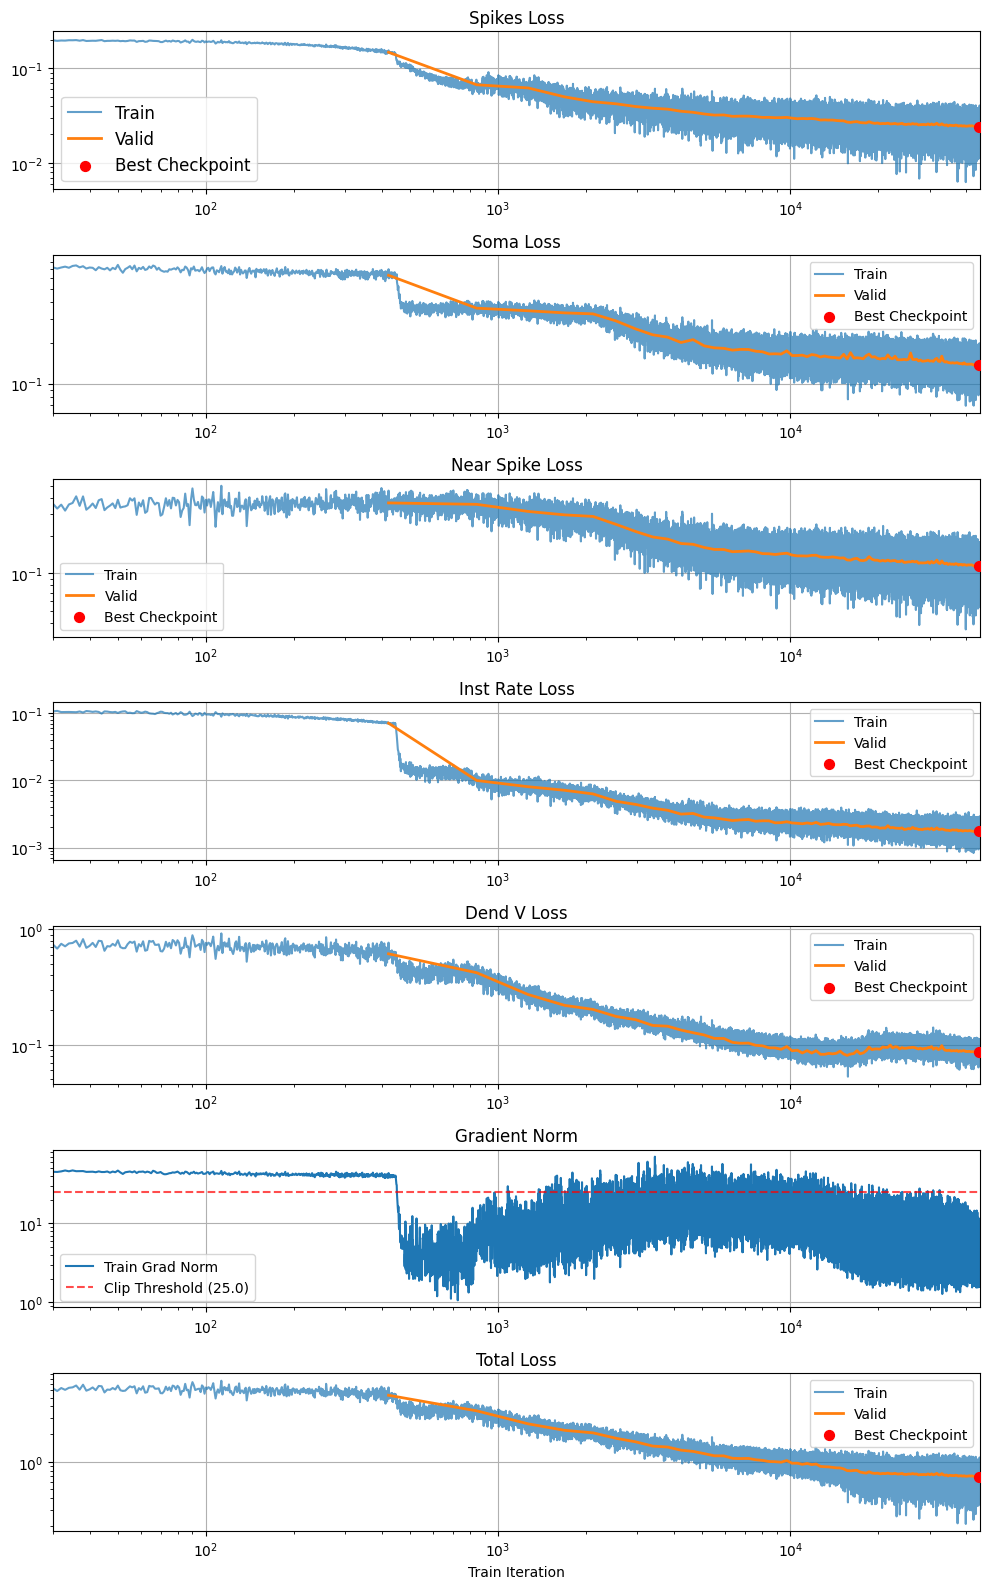

In [15]:
plt.figure(figsize=(10, 16))
num_subplots = 7

# Spikes loss
plt.subplot(num_subplots, 1, 1)
plt.plot(train_iter_list, train_losses_spikes, label='Train', alpha=0.7)
plt.plot(valid_iter_list, valid_losses_spikes, label='Valid', linewidth=2)
if best_valid_iter >= 0 and best_checkpoint_losses:
    plt.scatter(best_valid_iter, best_checkpoint_losses['valid_loss_spikes'], 
               color='red', s=50, marker='o', zorder=5, label='Best Checkpoint')
plt.title('Spikes Loss')
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xlim([30, max(train_iter_list)])

# Soma loss
plt.subplot(num_subplots, 1, 2)
plt.plot(train_iter_list, train_losses_soma, label='Train', alpha=0.7)
plt.plot(valid_iter_list, valid_losses_soma, label='Valid', linewidth=2)
if best_valid_iter >= 0 and best_checkpoint_losses:
    plt.scatter(best_valid_iter, best_checkpoint_losses['valid_loss_soma'], 
               color='red', s=50, marker='o', zorder=5, label='Best Checkpoint')
plt.title('Soma Loss')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xlim([30, max(train_iter_list)])

# Near spike loss
plt.subplot(num_subplots, 1, 3)
plt.plot(train_iter_list, train_losses_near_spike, label='Train', alpha=0.7)
plt.plot(valid_iter_list, valid_losses_near_spike, label='Valid', linewidth=2)
if best_valid_iter >= 0 and best_checkpoint_losses:
    plt.scatter(best_valid_iter, best_checkpoint_losses['valid_loss_near_spike'], 
               color='red', s=50, marker='o', zorder=5, label='Best Checkpoint')
plt.title('Near Spike Loss')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xlim([30, max(train_iter_list)])

# Instantaneous rate loss
plt.subplot(num_subplots, 1, 4)
plt.plot(train_iter_list, train_losses_inst_rate, label='Train', alpha=0.7)
plt.plot(valid_iter_list, valid_losses_inst_rate, label='Valid', linewidth=2)
if best_valid_iter >= 0 and best_checkpoint_losses:
    plt.scatter(best_valid_iter, best_checkpoint_losses['valid_loss_inst_rate'], 
               color='red', s=50, marker='o', zorder=5, label='Best Checkpoint')
plt.title('Inst Rate Loss')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xlim([30, max(train_iter_list)])

# Dendritic voltage loss
plt.subplot(num_subplots, 1, 5)
plt.plot(train_iter_list, train_losses_dend_v, label='Train', alpha=0.7)
plt.plot(valid_iter_list, valid_losses_dend_v, label='Valid', linewidth=2)
if best_valid_iter >= 0 and best_checkpoint_losses:
    plt.scatter(best_valid_iter, best_checkpoint_losses['valid_loss_dend_v'], 
               color='red', s=50, marker='o', zorder=5, label='Best Checkpoint')
plt.title('Dend V Loss')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xlim([30, max(train_iter_list)])

# Gradient norm
plt.subplot(num_subplots, 1, 6)
plt.plot(train_iter_list, train_grad_norms, label='Train Grad Norm')
if max_grad_norm is not None:
    plt.axhline(y=max_grad_norm, color='red', linestyle='--', alpha=0.7, 
               label=f'Clip Threshold ({max_grad_norm})')
plt.title('Gradient Norm')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xlim([30, max(train_iter_list)])

# Total loss
plt.subplot(num_subplots, 1, 7)
plt.plot(train_iter_list, train_losses_total, label='Train', alpha=0.7)
plt.plot(valid_iter_list, valid_losses_total, label='Valid', linewidth=2)
if best_valid_iter >= 0 and best_checkpoint_losses:
    plt.scatter(best_valid_iter, best_checkpoint_losses['valid_loss_total'], 
               color='red', s=50, marker='o', zorder=5, label='Best Checkpoint')
plt.title('Total Loss')
plt.xlabel('Train Iteration')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xlim([30, max(train_iter_list)])

plt.tight_layout()
plt.show()


In [16]:
# Store learning curves in model metadata
learning_curves_dict = {
    'learning_rate_list': learning_rate_list,
    'train_iter_list': train_iter_list,
    'train_losses_spikes': train_losses_spikes,
    'train_losses_soma': train_losses_soma,
    'train_losses_dend_v': train_losses_dend_v,
    'train_losses_inst_rate': train_losses_inst_rate,
    'train_losses_near_spike': train_losses_near_spike,
    'train_losses_total': train_losses_total,
    'train_losses_weights_spikes': train_losses_weights_spikes,
    'train_losses_weights_soma': train_losses_weights_soma,
    'train_losses_weights_dend_v': train_losses_weights_dend_v,
    'train_losses_weights_inst_rate': train_losses_weights_inst_rate,
    'train_losses_weights_near_spike': train_losses_weights_near_spike,
    'train_grad_norms': train_grad_norms,
    'valid_iter_list': valid_iter_list,
    'valid_losses_spikes': valid_losses_spikes,
    'valid_losses_soma': valid_losses_soma,
    'valid_losses_dend_v': valid_losses_dend_v,
    'valid_losses_inst_rate': valid_losses_inst_rate,
    'valid_losses_near_spike': valid_losses_near_spike,
    'valid_losses_total': valid_losses_total,
    'valid_losses_weights_spikes': valid_losses_weights_spikes,
    'valid_losses_weights_soma': valid_losses_weights_soma,
    'valid_losses_weights_dend_v': valid_losses_weights_dend_v,
    'valid_losses_weights_inst_rate': valid_losses_weights_inst_rate,
    'valid_losses_weights_near_spike': valid_losses_weights_near_spike,
}

twin_model.set_metadata_learning_curves(learning_curves_dict)
print('Learning curves stored in model metadata')


Learning curves stored in model metadata


## 15. Model Evaluation on Test Set

Now we evaluate the trained model on the test dataset. This comprehensive evaluation computes various metrics including:
- ROC curves and AUC scores for spike detection
- Explained variance and error metrics for voltage predictions
- Performance on instantaneous firing rate estimation

This evaluation gives us a thorough understanding of the model's predictive capabilities.


In [17]:
# Evaluate model on test set
valid_metrics_dict = evaluate_model_on_dataset(twin_model, test_dataset, batch_size=test_batch_size, verbose=1)

# Print metrics summary
print('--------------------------------------------------')
print('Evaluation Metrics:')
print('--------------------------------------------------')

interesting_keys = [
    'requested_false_positive_rate', 'true_positive_at_FP', 'AUC_score',
    'near_spike_true_positive_at_FP', 'near_spike_AUC_score',
    'soma_explained_variance_percent', 'soma_RMSE', 'soma_MAE',
    'inst_rate_explained_variance_percent', 'inst_rate_RMSE', 'inst_rate_MAE',
    'dend_v_explained_variance_percent', 'dend_v_RMSE', 'dend_v_MAE']

for key in interesting_keys:
    start_string = f"  {key}"
    filler_string = ' ' * (50 - len(start_string))
    print(f"{start_string} {filler_string} = {valid_metrics_dict[key]:.5f}")
print('--------------------------------------------------')

# Store the evaluation metrics in the model metadata
twin_model.set_metadata_eval_metrics(valid_metrics_dict)


Spikes AUC = 0.9755
at 0.0020 FP rate, TP = 0.2483
Near spike AUC = 0.9802
at 0.0020 FP rate, TP = 0.3986
soma voltage prediction explained variance = 66.12%
soma RMSE = 3.01 (mV)
soma MAE = 1.54 (mV)
inst rate explained variance = 85.73%
inst rate RMSE = 0.0041
inst rate MAE = 0.0023
dend v explained variance = 93.61%
dend v RMSE = 5.94 (mV)
dend v MAE = 3.62 (mV)
--------------------------------------------------
Evaluation Metrics:
--------------------------------------------------
  requested_false_positive_rate                     = 0.00200
  true_positive_at_FP                               = 0.24828
  AUC_score                                         = 0.97555
  near_spike_true_positive_at_FP                    = 0.39864
  near_spike_AUC_score                              = 0.98024
  soma_explained_variance_percent                   = 66.11673
  soma_RMSE                                         = 3.01289
  soma_MAE                                          = 1.54279
  inst_rate_e

## 16. Visualization of Evaluation Metrics

Plot comprehensive evaluation figures showing ROC curves, precision-recall curves, and scatter plots comparing predictions to ground truth for all output variables.


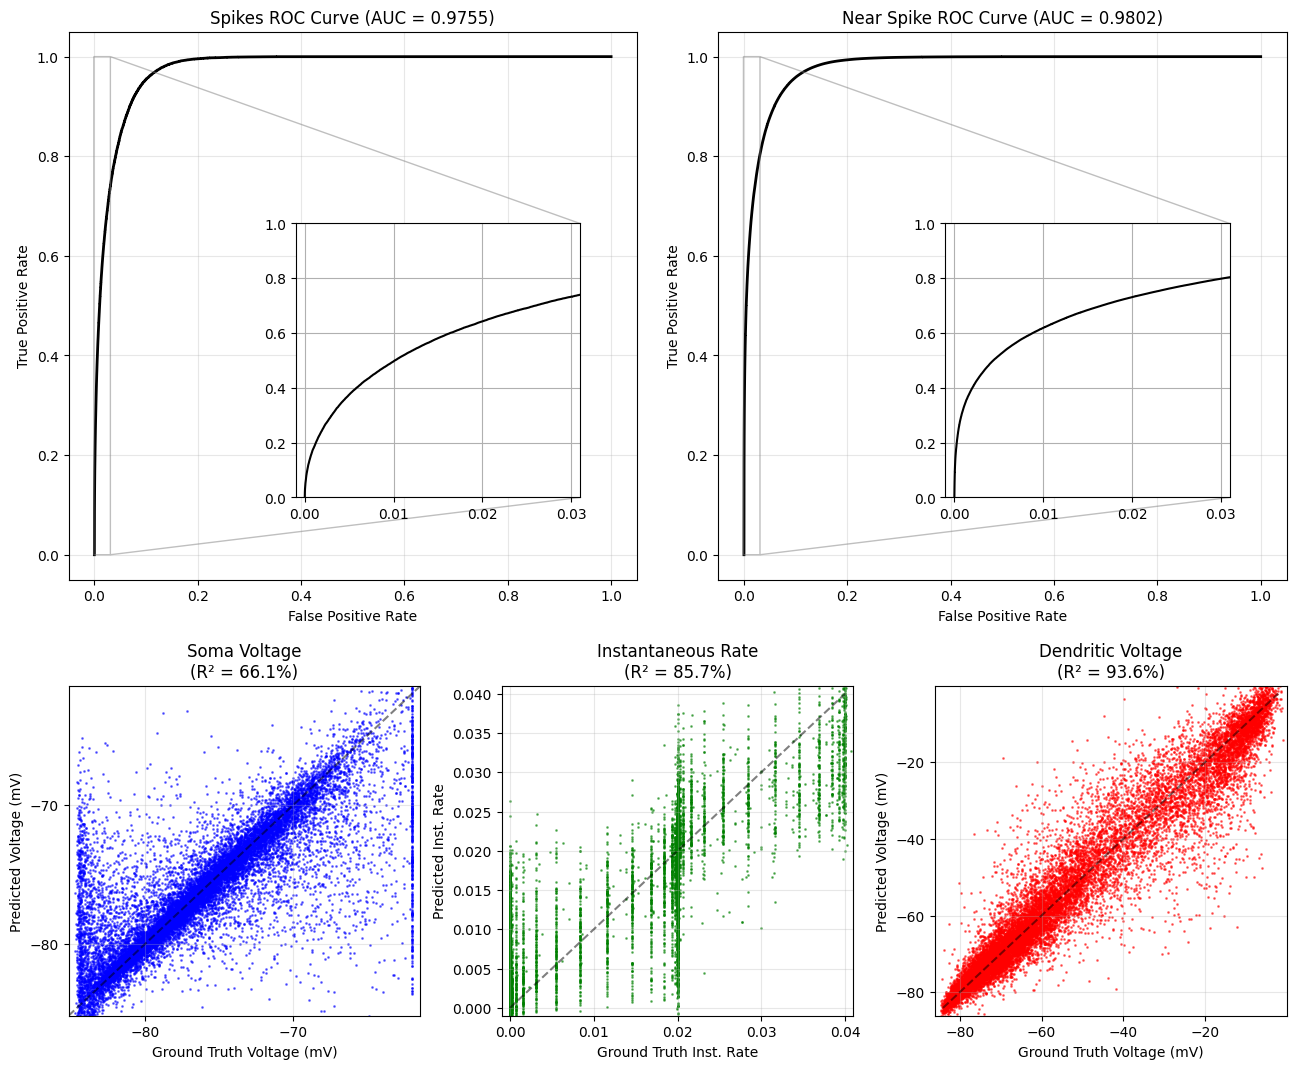

In [18]:
# Plot evaluation figures
fig = plot_evaluation_figures(valid_metrics_dict)
plt.show()


## 17. Sample Predictions

Let's examine the model's predictions on a random sample from the test dataset. We'll visualize both a minimal version (showing inputs, spikes, and soma voltage) and a full version (showing all five output heads).


Selected sample: sim_0000224.npy
X_inputs shape: (8, 8192, 2), dtype: float16
y_spike shape: (8192,), dtype: bool
y_soma shape: (8192,), dtype: float32
---------------------------------------------------------
Metrics for current sample:
---------------------------
Total number of GT spikes: 25 (3.05 Hz)
Spike Detection:
  Precision: 0.7500
  Recall: 0.3600
  AUC: 0.9942
Voltage Prediction:
  MAE: 0.88 mV
  RMSE: 1.92 mV
  R²: 0.8006
---------------------------------------------------------


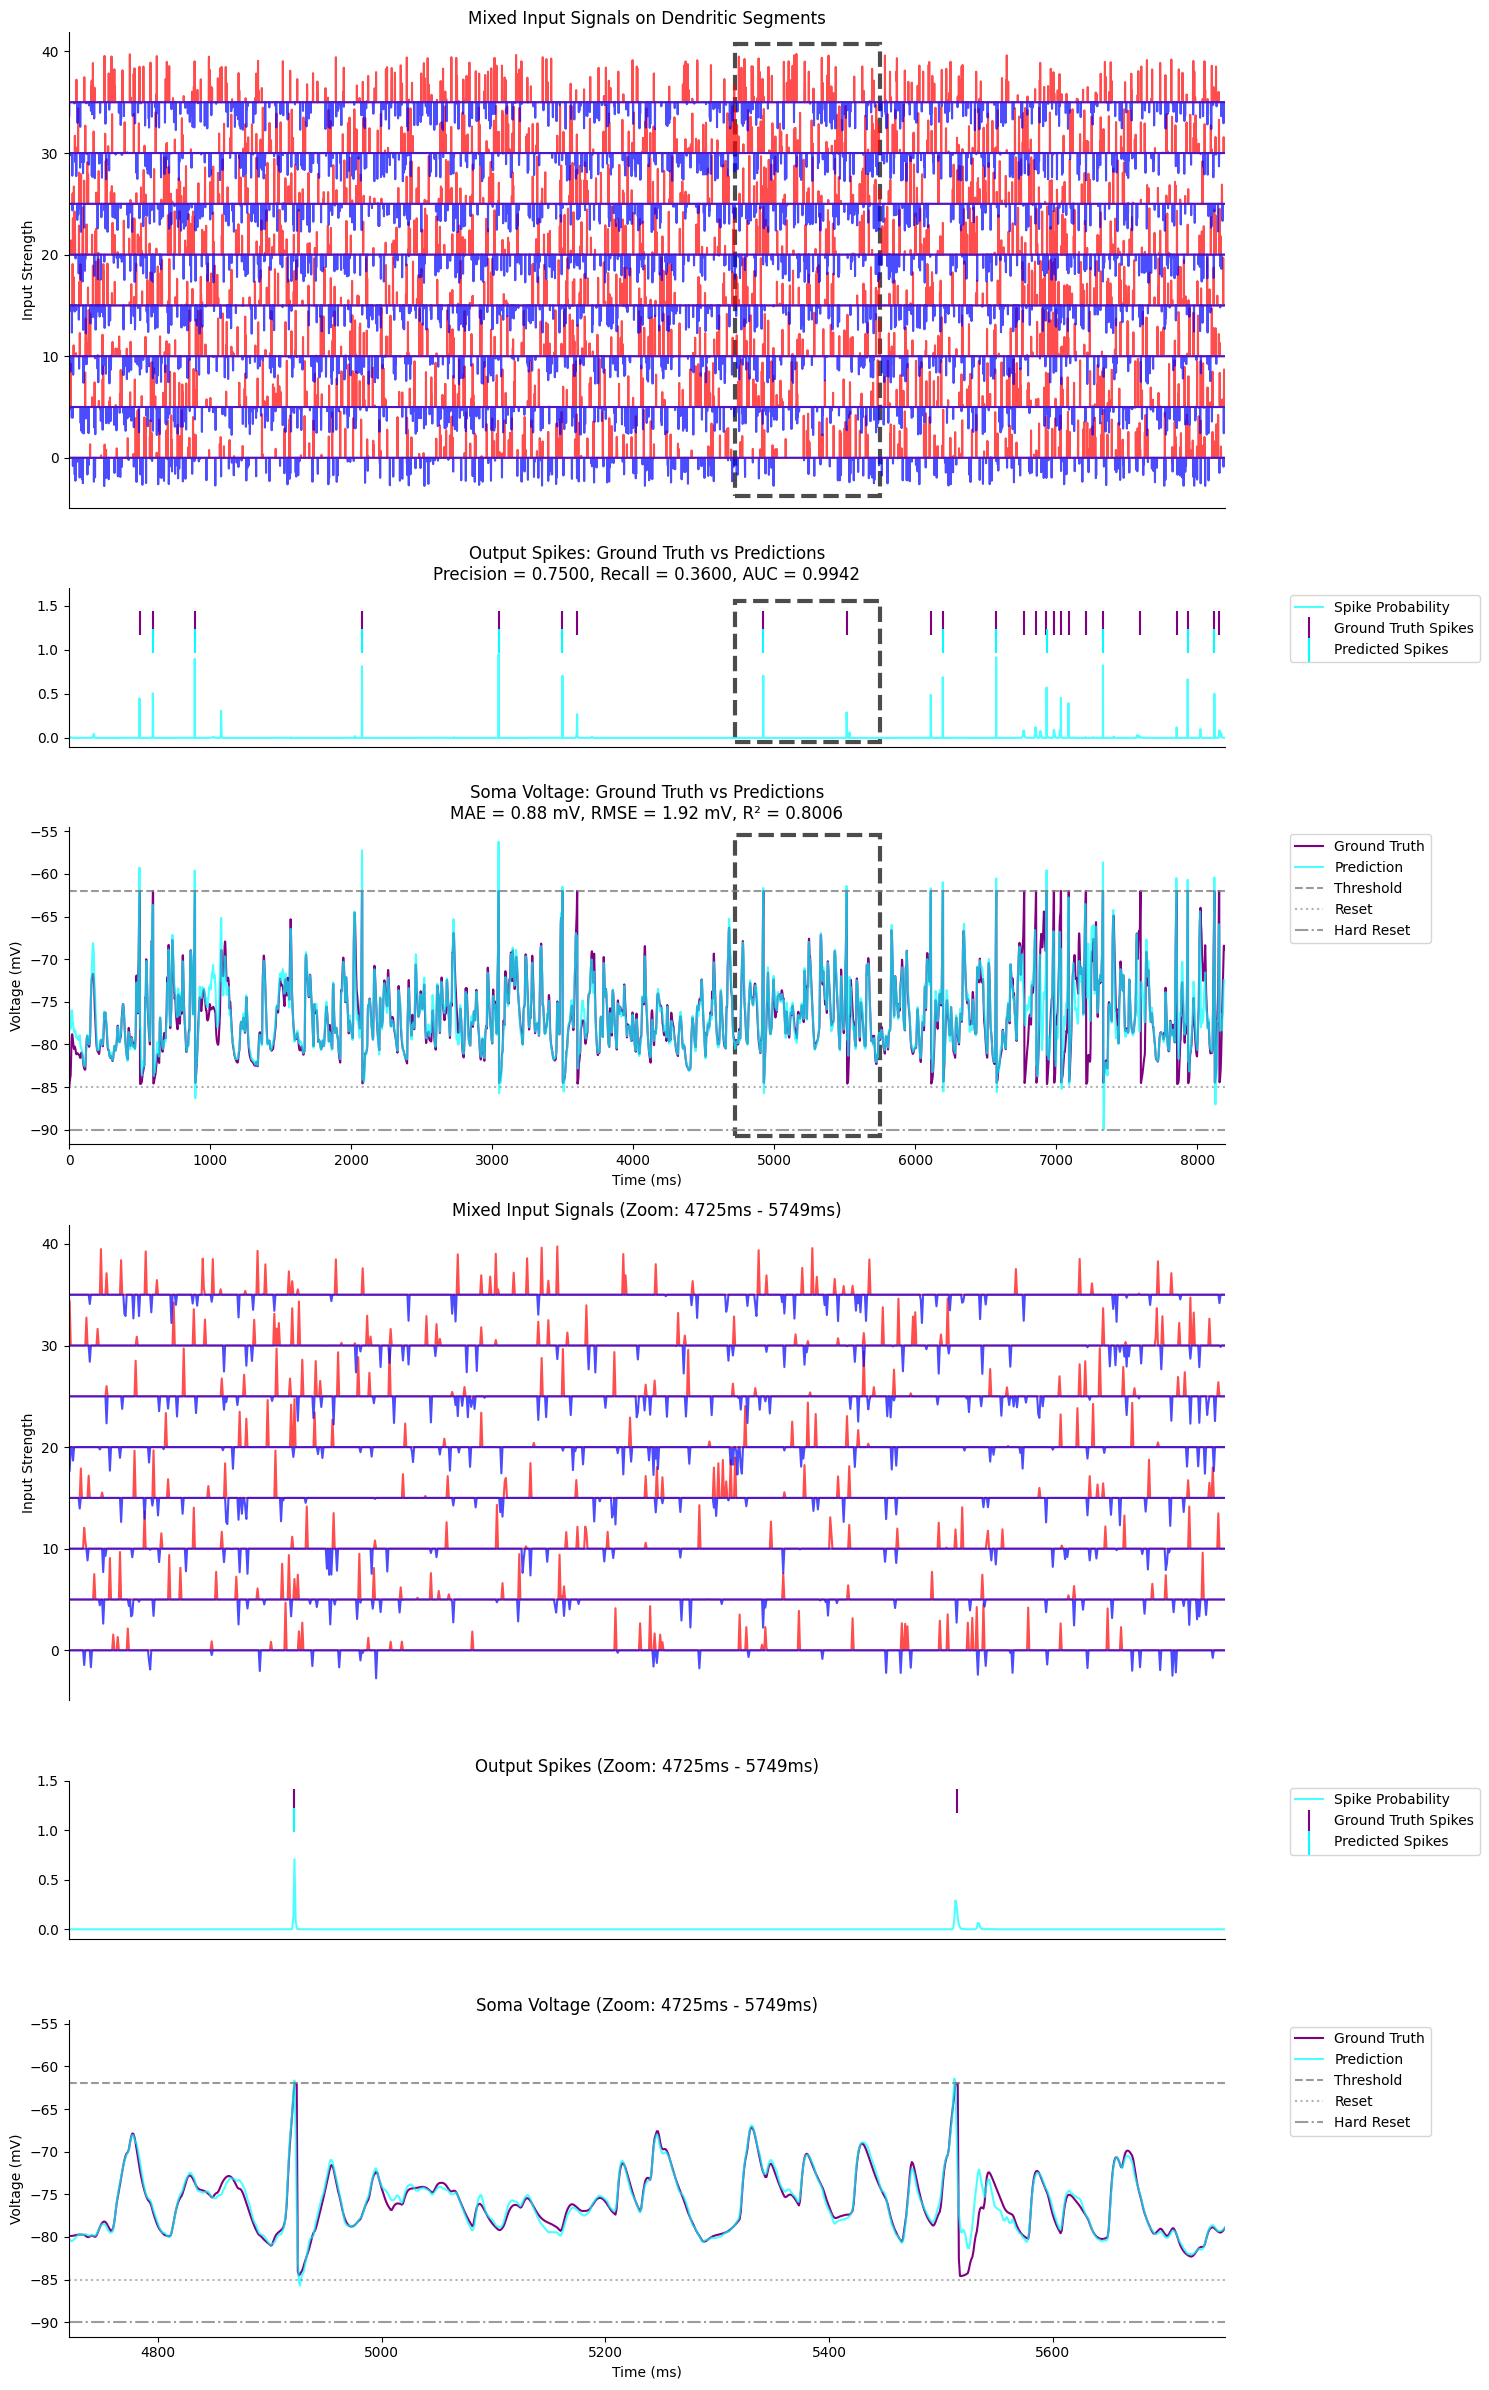

In [19]:
# load a random sample from test dataset and run the model on it
sample_filename = np.random.choice(glob.glob(os.path.join(test_data_folder, 'output_spikes', '*.npy')))
sample_basename = os.path.basename(sample_filename)

# display the sample predictions (minimal form - just input, spikes, soma voltage)
fig = display_sample_predictions_minimal(twin_model, test_data_folder, bs_neuron, sample_basename)
plt.show()


Selected sample: sim_0000224.npy
X_inputs shape: (8, 8192, 2), dtype: float16
y_spike_gt shape: (8192,), dtype: bool
y_soma_gt shape: (8192,), dtype: float32
y_near_spike_gt shape: (8192,), dtype: bool
y_inst_rate_gt shape: (8192,), dtype: float32
y_dend_v_gt shape: (8, 8192), dtype: float32
---------------------------------------------------------
Metrics for current sample:
---------------------------
Total number of GT spikes: 25 (3.05 Hz)
Spike Detection:
  Precision: 0.7500
  Recall: 0.3600
  AUC: 0.9942
Soma Voltage Prediction:
  MAE: 0.88 mV
  RMSE: 1.92 mV
  R²: 0.8006
Near Spike Prediction:
  AUC: 0.9919
Instantaneous Rate Prediction:
  MAE: 0.0014
  RMSE: 0.0029
  R²: 0.8274
Dendritic Voltage Prediction:
  MAE: 2.73 mV
  RMSE: 4.70 mV
  R²: 0.9056
---------------------------------------------------------


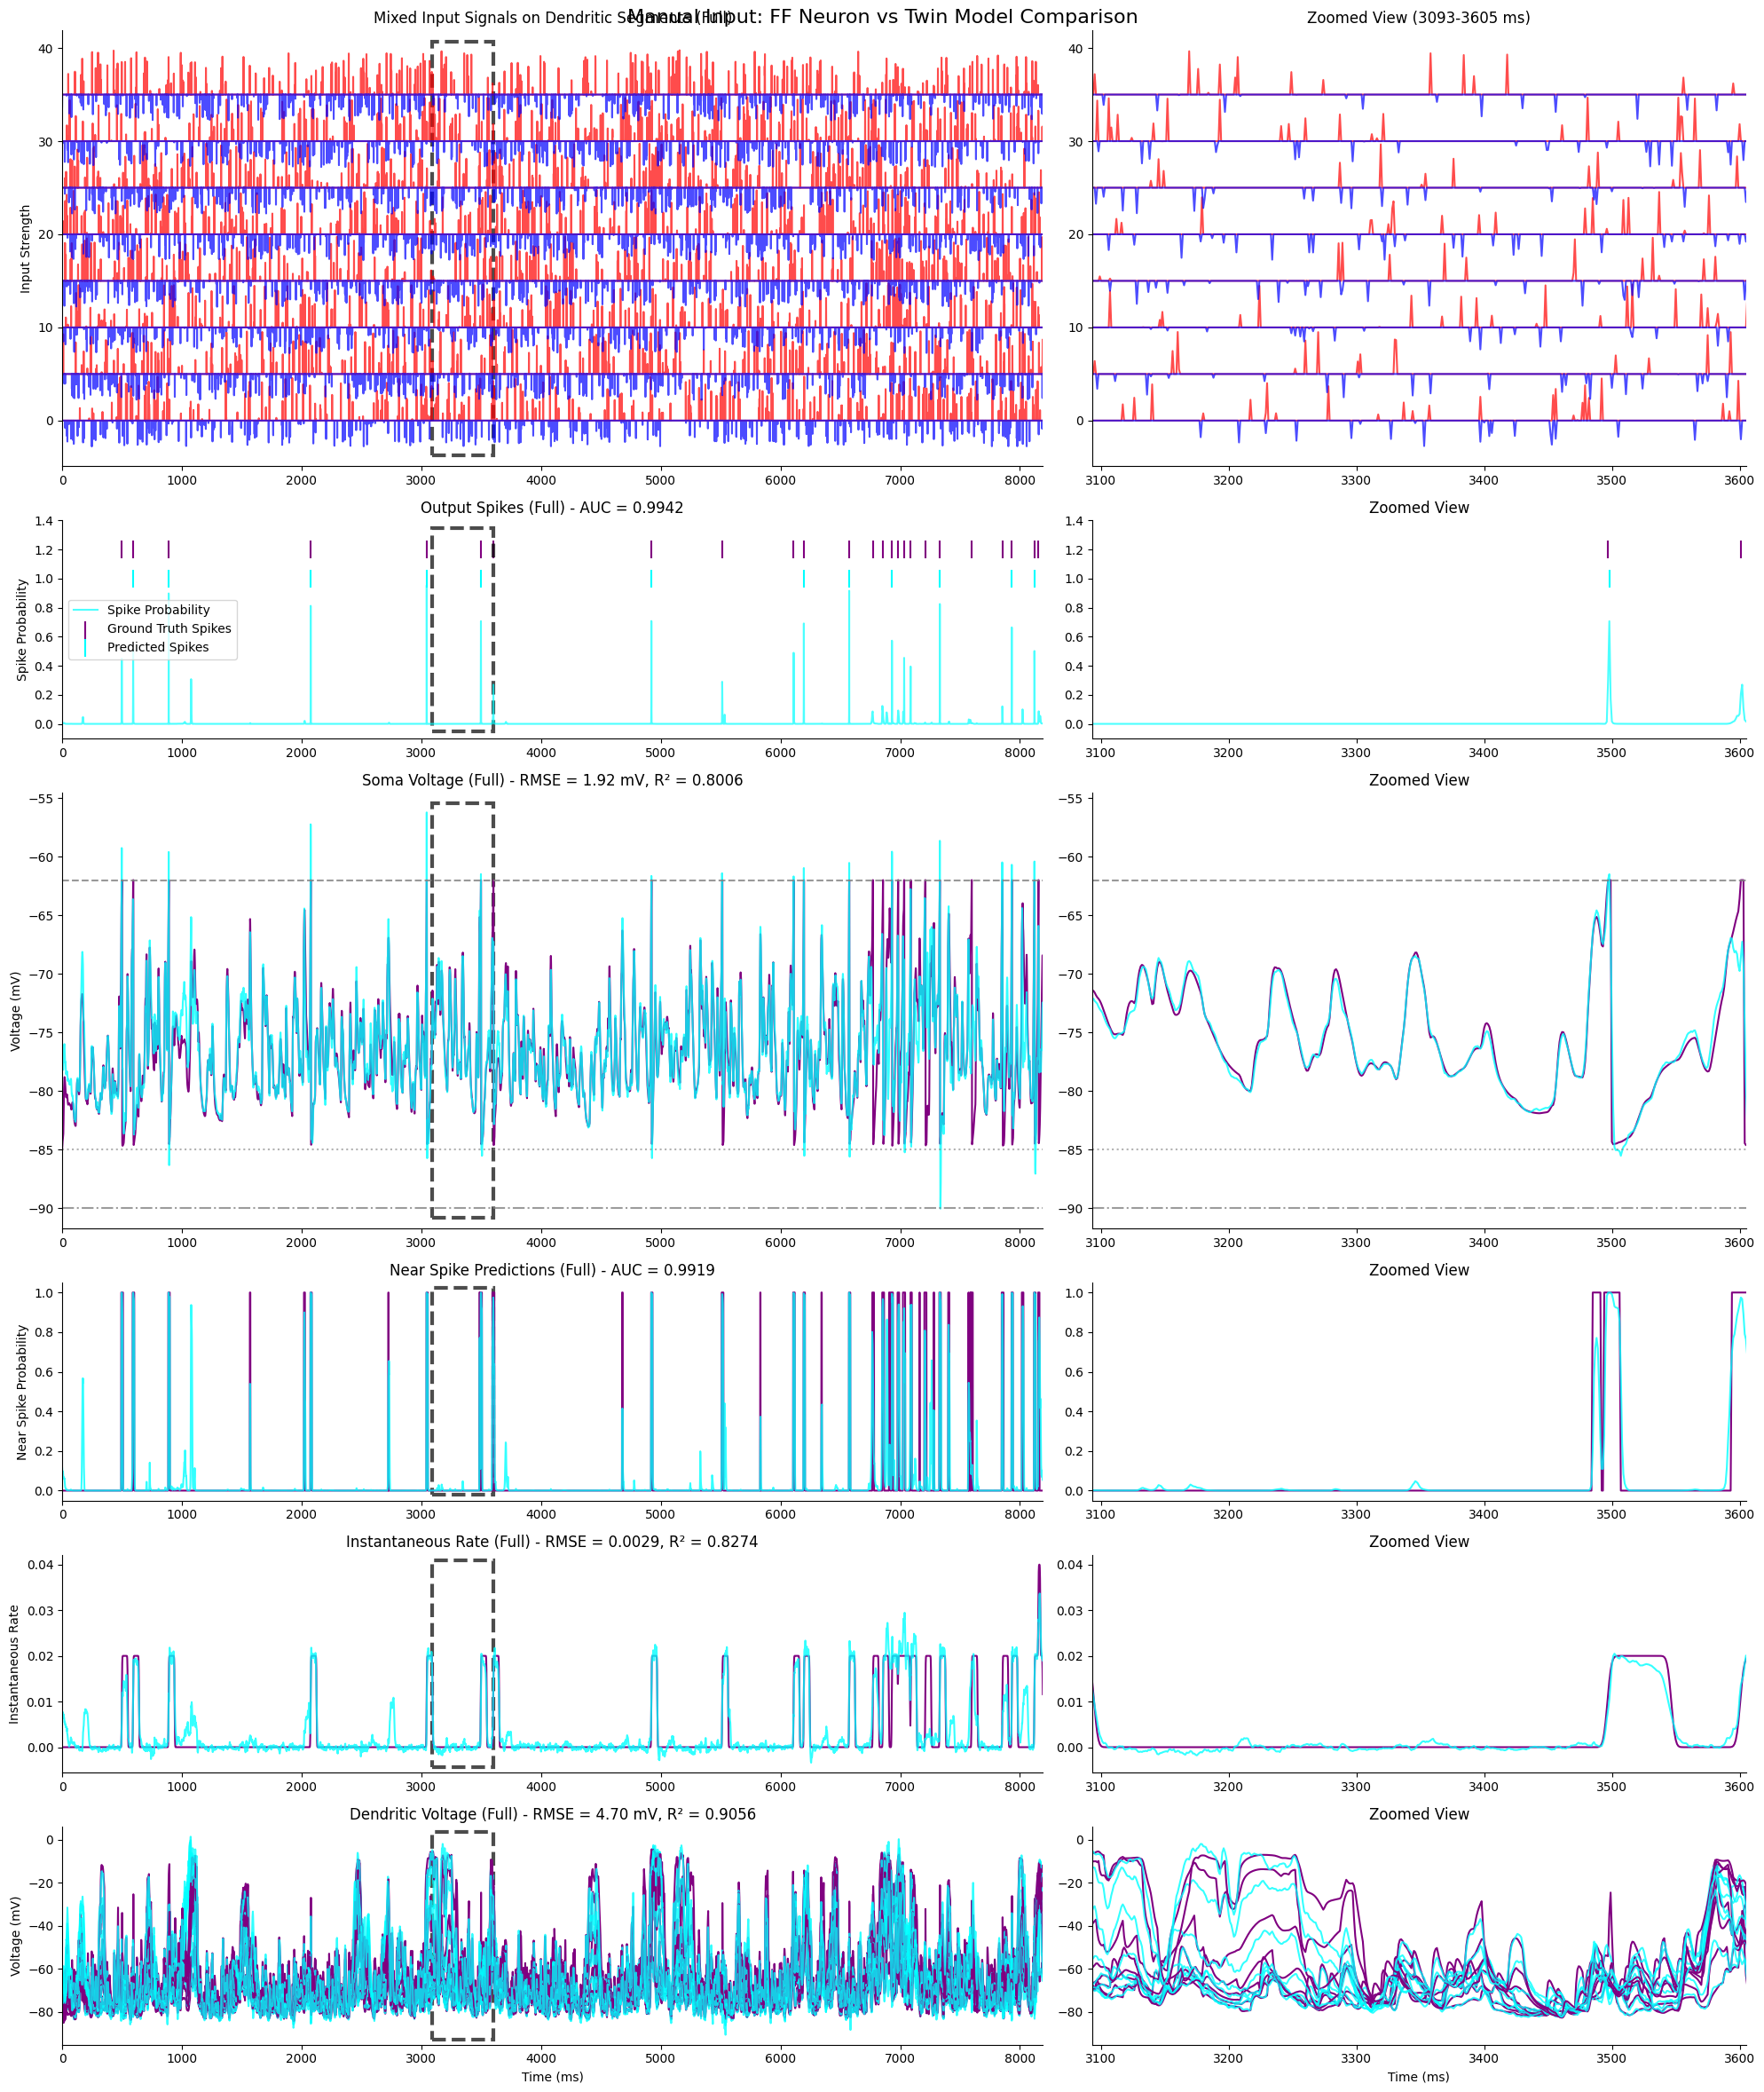

In [20]:
# display the sample predictions (full form - all 5 outputs: spikes, soma, near_spike, inst_rate, dend_v)
fig = display_sample_predictions_full(twin_model, test_data_folder, bs_neuron, sample_basename)
plt.show()


## 18. Model Calibration Check

An important aspect of probabilistic predictions is calibration - whether the predicted probabilities match the actual frequencies of events. We analyze the calibration of our spike probability predictions by binning predicted probabilities and comparing to actual spike rates.


In [21]:
num_bins_per_simulation = 8

# fetch test data predictions (use the soma voltage predictions are as they are from model output)
output_dict = predict_on_all_simulations(twin_model, test_dataset, batch_size=test_batch_size)

y_spikes_pred = output_dict['y_spikes_pred']
y_spikes_gt = output_dict['y_spikes_gt']

calib_corr, calib_explained_var = calculate_calibration_metrics(y_spikes_pred, y_spikes_gt, num_bins_per_simulation=num_bins_per_simulation)
print(f'Calibration Correlation: {calib_corr:.4f}')
print(f'Calibration Explained Variance Percent: {100 * calib_explained_var:.2f}%')

Calibration Correlation: 0.9919
Calibration Explained Variance Percent: 98.38%


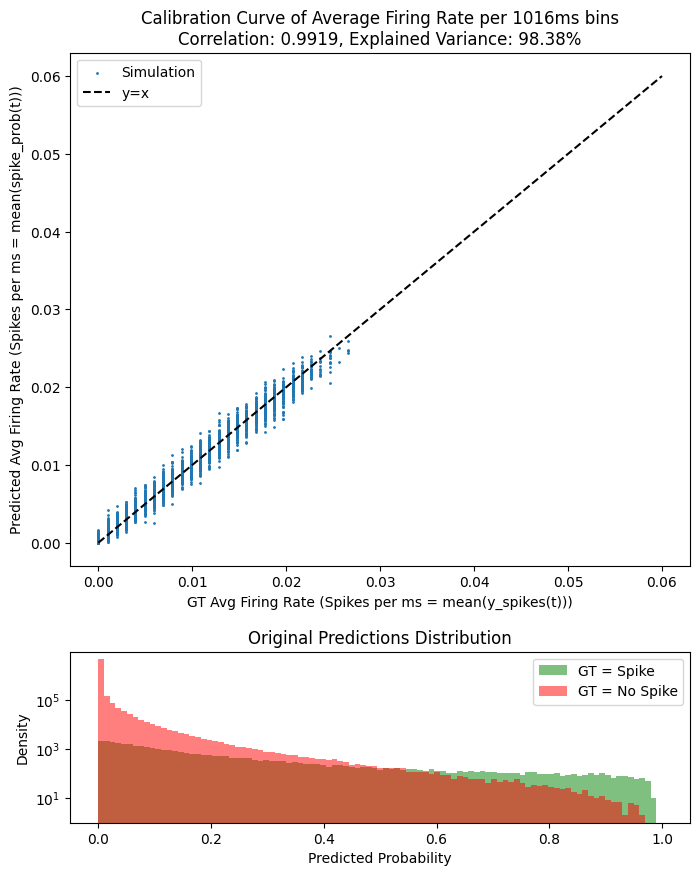

In [22]:
# Display calibration figure
fig = display_calibration_figure(y_spikes_pred, y_spikes_gt, num_bins_per_simulation=num_bins_per_simulation)

## 19. Save the Trained Model

Finally, we save the trained model to disk with a descriptive filename that includes performance metrics. The model file contains not only the trained weights but also all metadata about the training process and evaluation results.


In [23]:
save_model_to_disk = True
# save_model_to_disk = False

if save_model_to_disk:
    valid_acc_str = f'_AUC_0_{10000 * valid_metrics_dict["AUC_score"]:.0f}'
    valid_acc_str += f'_somaR2_{10 * valid_metrics_dict["soma_explained_variance_percent"]:.0f}'
    calib_str = f'_calibR2_{10000 * calib_explained_var:.0f}'
    checkpoint_model_name_pt = bs_neuron.short_name + '_' + twin_model.short_name + f"{valid_acc_str}_{calib_str}.pt"
    twin_model.save_model(os.path.join(models_folder, checkpoint_model_name_pt))

    print(f'Model saved to folder "{models_folder}"')
    print(f'checkpoint name = "{checkpoint_model_name_pt}"')
else:
    print('Model not saved (save_model_to_disk = False)')


Saved model to "/home/davidbeniaguev/Desktop/Models/BS_neuron_twin_models/BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs/BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs_TCN_D_5_W_32_T_201_params_190K_AUC_0_9755_somaR2_661__calibR2_9838.pt"
Model saved to folder "/home/davidbeniaguev/Desktop/Models/BS_neuron_twin_models/BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs"
checkpoint name = "BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs_TCN_D_5_W_32_T_201_params_190K_AUC_0_9755_somaR2_661__calibR2_9838.pt"


## Summary

Congratulations! You've successfully trained a deep neural network to act as a "twin" of a biophysically detailed ball-and-stick neuron. 

### Key achievements:

1. **Multi-task learning**: The model learned to predict multiple outputs simultaneously (spikes, soma voltage, dendritic voltage, instantaneous rate, and near-spike indicators)

2. **Dynamic loss weighting**: Loss weights were adjusted during training to balance different objectives

3. **Comprehensive evaluation**: We assessed the model using multiple metrics including AUC scores, explained variance, and calibration analysis

4. **Probabilistic predictions**: The model produces well-calibrated probability estimates for spike occurrence

### Next steps:

- Try different model architectures (ResNetTCN, ELM, Transformer) by changing the `twin_model_type` parameter
- Experiment with different hyperparameters (learning rate, number of epochs, model size)
- Test the model on different neuron morphologies
- Use the trained twin model for rapid simulation or parameter exploration

The trained model can now serve as a fast approximation of the original biophysical neuron, enabling applications that require many rapid simulations.
